# ***Lab 1: Gaia, RR Lyrae stars, and Galactic Dust***
## **ASTRON 128 – Fall 2024**
### *Vardaan Tekriwal*

#### **Imports and Caching**

The caching function has the following functionality:

"""
    Execute a Gaia query and parse the results into a pandas DataFrame.
    Save the results to a file for future use. If no filename is provided,
    it guesses the output filename based on the query.
    
    Parameters:
    - query: str, the query to execute
    - local_filename: str, optional, the filename to save or load the results
    - verbose: bool, optional, whether to print verbose output
    - overwrite: bool, optional, whether to overwrite the existing file
    
    Returns: dataframe
    """

In [2]:
import os
import time
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astropy.table import Table
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from astropy import units as u
from astropy.timeseries import LombScargle
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip
import pymc as pm
import arviz as az
import matplotlib.patches as mpatches
from astropy.coordinates import SkyCoord
import pymc.math as pm_math
import pytensor.tensor as at
from dustmaps.sfd import SFDQuery
import dustmaps.config as dm_config
from dustmaps.config import config
import dustmaps.sfd

%matplotlib inline

1. The gaiadr3.vari_rrlyrae catalog contains the results of RR Lyrae classification done by the Gaia data processing and analysis consortium for more than 105 RR Lyrae stars. Write an ADQL query to download the first 100 rows of the table for which a fundamental pulsation frequency (“pf”) has been measured and more than 40 clean epochs were obtained in the G-band. Submit your query using Astroquery and display the first 10 rows of the thus-obtained catalog. To find the meaning of individual columns, you can search for them in the Gaia DR3 data model. To learn about the meaning of RR Lyrae–specific parameters and how they were derived, see Clementini et al. 2016 and Celmentini et al. 2022. Table 12 lists the relevant columns for the data your download from the Gaia archive.

In [3]:
def get_and_parse_cached_gaia_query(query, local_filename=None, verbose=True, overwrite=False):
    
    # Create a default filename based on a hash of the query if not provided
    if local_filename is None:
        local_filename = f"gaia_query_{hash(query)}.csv"
        
    if not os.path.exists(local_filename) or overwrite:
        start = time.time()
        job = Gaia.launch_job(query)
        results = job.get_results()
        
        df = results.to_pandas()
        df.to_csv(local_filename, index=False)
        
        if verbose:
            print(f"Wrote the file {local_filename} to disk", flush=True)
            print(f"  Total time: {time.time() - start:0.3} sec")
    else:
        start = time.time()
        if verbose:
            print(f"Reading the file {local_filename} from disk")
        df = pd.read_csv(local_filename)
        if verbose:
            print(f"  Total time: {time.time() - start:0.3} sec")
    return df


In [4]:
query = """
SELECT TOP 100 *
FROM gaiadr3.vari_rrlyrae
WHERE pf IS NOT NULL
AND num_clean_epochs_g > 40
"""

rr_lyrae_df = get_and_parse_cached_gaia_query(query, "rrlyrae_gaia_data.csv", verbose=True, overwrite = False)
rr_lyrae_df.head(10)

Reading the file rrlyrae_gaia_data.csv from disk
  Total time: 0.00864 sec


solution_id           SOURCE_ID        pf  pf_error  p1_o  \
0  375316653866487565  245002531050576896  0.520512  0.000006   NaN   
1  375316653866487565  245504251951140864  0.507115  0.000004   NaN   
2  375316653866487565  245823861938360064  0.478764  0.000003   NaN   
3  375316653866487565  246756973652292992  0.489303  0.000003   NaN   
4  375316653866487565  359112665277840512  0.501780  0.000003   NaN   
5  375316653866487565  414003442535159936  0.474868  0.000003   NaN   
6  375316653866487565  414081061185873792  0.588920  0.000003   NaN   
7  375316653866487565  414152842984521856  0.364381  0.000016   NaN   
8  375316653866487565  414254032403091072  0.418104  0.000004   NaN   
9  375316653866487565  415000566440590976  0.617383  0.000004   NaN   

   p1_o_error      epoch_g  epoch_g_error     epoch_bp  epoch_bp_error  ...  \
0         NaN  1705.132336       0.000008  1705.141478        0.000010  ...   
1         NaN  1705.941237       0.000006  1705.959324        0.000018  ...   
2         NaN  1705.224346       0.000004  1705.720646        0.000042  ...   
3         NaN  1705.694932       0.000004  1705.689886        0.000004  ...   
4         NaN  1700.672707       0.000004  1700.674042        0.000002  ...   
5         NaN  1699.303859       0.000004  1699.307985        0.000007  ...   
6         NaN  1698.628868       0.000004  1698.665720        0.000010  ...   
7         NaN  1699.044868       0.000023          NaN             NaN  ...   
8         NaN  1699.358285       0.000006  1699.372824        0.000023  ...   
9         NaN  1697.739636       0.000005  1697.741188        0.000006  ...   

                   fund_freq1_harmonic_ampl_rp_error  \
0  [0.010494326241314411 0.016995785757899284 0.0...   
1  [0.0760503038764 0.047721847891807556 0.060700...   
2  [0.031176093965768814 0.035711657255887985 -- ...   
3  [0.030727090314030647 0.047870539128780365 0.0...   
4  [0.018822116777300835 0.013632036745548248 0.0...   
5  [0.020318111404776573 0.022703826427459717 0.0...   
6  [0.0256697665899992 -- -- -- -- -- -- -- -- --...   
7                                                NaN   
8  [0.02068113349378109 0.03187503293156624 -- --...   
9  [0.004727639257907867 0.005540942773222923 0.0...   

                        fund_freq1_harmonic_phase_rp  \
0  [1.1146807670593262 0.1373586654663086 5.74105...   
1  [4.1733903884887695 5.874802589416504 3.042095...   
2  [2.76688814163208 3.016339063644409 0.0 0.0 0....   
3  [4.562902450561523 0.4658964276313782 3.892376...   
4  [2.2174336910247803 1.9805796146392822 2.17451...   
5  [3.2704927921295166 4.007861137390137 5.968933...   
6  [3.2015879154205322 0.0 0.0 0.0 0.0 0.0 0.0 0....   
7                                                NaN   
8  [5.0545525550842285 1.57941734790802 0.0 0.0 0...   
9  [4.1175217628479 0.6510999202728271 3.58330011...   

                  fund_freq1_harmonic_phase_rp_error  \
0  [0.06407403200864792 0.13510026037693024 0.176...   
1  [0.4473535418510437 0.3156072497367859 0.54333...   
2  [0.3435215651988983 0.5497013330459595 -- -- -...   
3  [0.13615591824054718 0.6346452236175537 0.8997...   
4  [0.04635436832904816 0.18070566654205322 0.199...   
5  [0.23768164217472076 0.5128516554832458 0.6803...   
6  [1.6511130332946777 -- -- -- -- -- -- -- -- --...   
7                                                NaN   
8  [0.28810054063796997 0.6072249412536621 -- -- ...   
9  [0.06876092404127121 0.1189626082777977 0.3158...   

                         fund_freq1_harmonic_ampl_rv  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  [24.761327743530273 8.276593208312988 6.709530...   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   
8  

2. The table you downloaded above contains the results of fitting the light curves of RR Lyrae stars, but it does not contain the raw light curves. The raw light curves can be accessed as described in the Datalink and light curves tutorial. Download the light curves (i.e., G-band magnitude vs. time, with magnitude uncertainties) for the 100 RR Lyrae stars in your table. This is most easily accomplished with a Python utility for fetching web urls. astroquery is one good option. Plot one of the light curves.
3. Estimate the period and mean G-band magnitude of the 100 light curves you downloaded above. A simple estimate of the period can be obtained using a Lomb-Scargle (L-S) periodogram. An implementation is available in astropy.timeseries.LombScargle. Plot the periodogram for one light curve, marking your estimate of the period on the plot.

In [5]:
rr_lyrae_df.columns

Index(['solution_id', 'SOURCE_ID', 'pf', 'pf_error', 'p1_o', 'p1_o_error',
       'epoch_g', 'epoch_g_error', 'epoch_bp', 'epoch_bp_error', 'epoch_rp',
       'epoch_rp_error', 'epoch_rv', 'epoch_rv_error', 'int_average_g',
       'int_average_g_error', 'int_average_bp', 'int_average_bp_error',
       'int_average_rp', 'int_average_rp_error', 'average_rv',
       'average_rv_error', 'peak_to_peak_g', 'peak_to_peak_g_error',
       'peak_to_peak_bp', 'peak_to_peak_bp_error', 'peak_to_peak_rp',
       'peak_to_peak_rp_error', 'peak_to_peak_rv', 'peak_to_peak_rv_error',
       'metallicity', 'metallicity_error', 'r21_g', 'r21_g_error', 'r31_g',
       'r31_g_error', 'phi21_g', 'phi21_g_error', 'phi31_g', 'phi31_g_error',
       'num_clean_epochs_g', 'num_clean_epochs_bp', 'num_clean_epochs_rp',
       'num_clean_epochs_rv', 'zp_mag_g', 'zp_mag_bp', 'zp_mag_rp',
       'num_harmonics_for_p1_g', 'num_harmonics_for_p1_bp',
       'num_harmonics_for_p1_rp', 'num_harmonics_for_p1_rv',
       '

In [6]:
source_id = 4659713442253931776 #add to dataset
query = f"""
SELECT *
FROM gaiadr3.vari_rrlyrae
WHERE source_id = {source_id}
"""
def get_specific_rrlyrae_data(query):
    job = Gaia.launch_job_async(query)
    result = job.get_results()
    return result.to_pandas()

specific_rr_lyrae_data = get_specific_rrlyrae_data(query)
print(f"Retrieved {len(specific_rr_lyrae_data)} rows for source_id {source_id}.")

INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 1 rows for source_id 4659713442253931776.


In [7]:
rr_lyrae_df = pd.concat([rr_lyrae_df, specific_rr_lyrae_data], ignore_index=True)

/var/folders/yb/gm3s7q8j7rjchq61y16sy76c0000gn/T/ipykernel_86203/4292612220.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rr_lyrae_df = pd.concat([rr_lyrae_df, specific_rr_lyrae_data], ignore_index=True)


In [9]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  vtekriwa
Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]


In [10]:
source_ids = rr_lyrae_df['SOURCE_ID'].tolist()

retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'INDIVIDUAL'
data_release = 'Gaia DR3'
format_type = 'votable'

datalink = Gaia.load_data(ids=source_ids, data_release=data_release, 
                          retrieval_type=retrieval_type, data_structure=data_structure, 
                          verbose=False, output_file=None, format=format_type)

dl_keys = [key for key in datalink.keys()]
dl_keys.sort()

print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')

The following Datalink products have been downloaded:
 * EPOCH_PHOTOMETRY-Gaia DR3 1933740099389964544.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1933774424769244672.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1933932037186583808.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934025701833533056.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934205880002515456.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934591533705740928.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934784777174637056.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1934869366550952448.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935104150941800320.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935230693559394816.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935418400810447744.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935591853067670912.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935623189149153664.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1935783924006493056.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936034303418884992.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936052754598476416.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936068285199840128.xml
 * EPOCH_PHOTOMETRY-Gaia DR3 1936256744066915

In [113]:
def estimate_period_lombscargle(time, magnitude, magnitude_error):
    time = np.array(time)
    min_period = 0.2  # days
    max_period = 1  # days
    frequency, power = LombScargle(time, magnitude, magnitude_error).autopower(
        minimum_frequency=1/max_period, 
        maximum_frequency=1/min_period
    )
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency

    return best_period, frequency, power

def calculate_mean_magnitude(flux, flux_err):
    mean_flux = np.mean(flux)
    mean_flux_err = np.sqrt(np.sum(flux_err**2)) / len(flux_err) 
    mean_mag = -2.5 * np.log10(mean_flux)
    mean_mag_err = (2.5 / np.log(10)) * (mean_flux_err / mean_flux)
    return mean_mag, mean_mag_err

def plot_light_curve(time, magnitude, magnitude_error, mean_magnitude, mean_magnitude_error):
    magnitude = magnitude.to(u.mag) 
    magnitude_error = magnitude_error.to(u.mag)
    plt.errorbar(
        time, magnitude.value, yerr=magnitude_error.value,
        fmt='o', label='G-band', color='blue',
        ecolor='black', elinewidth=1, capsize=2,
        markeredgewidth=1, markersize=1  # Reduced marker size
    )
    plt.axhline(
        mean_magnitude, color='red', linestyle='--',
        label=f'Mean Magnitude: {mean_magnitude:.3f} mag'
    )
    plt.fill_between(
        time, mean_magnitude - mean_magnitude_error, 
        mean_magnitude + mean_magnitude_error,
        color='red', alpha=0.2,
        label=f'± Mean Error: {mean_magnitude_error:.3f} mag'
    )
    plt.gca().invert_yaxis()  
    plt.xlabel('Time (JD)')
    plt.ylabel('G-band Magnitude')
    plt.title('Light Curve')
    plt.legend()
    plt.show()

def plot_periodogram(frequency, power, best_period):
    periods = 1 / frequency
    plt.plot(periods, power)
    plt.axvline(best_period, color='red', linestyle='--', label=f'Estimated Period: {best_period:.3f} days')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.title('Lomb-Scargle Periodogram')
    plt.legend()
    plt.show()

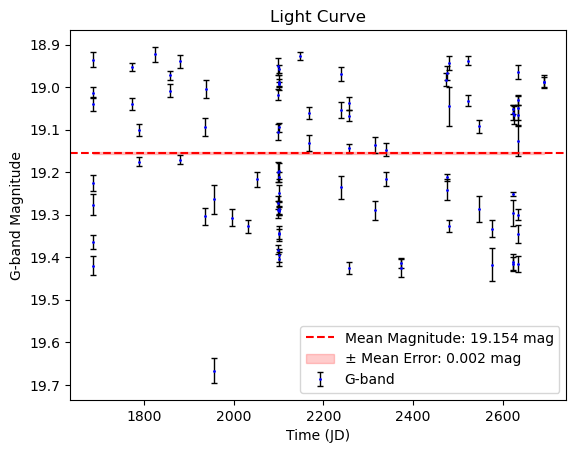

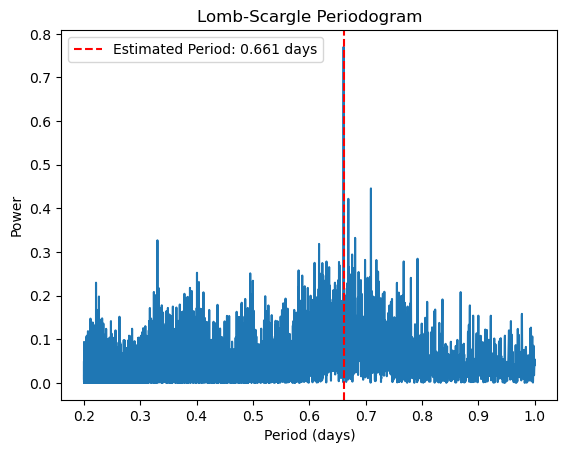

Estimated Period: 0.661 days
Mean G-band Magnitude: 19.154 ± 0.002


In [114]:
estimated_periods = []
mean_magnitudes = []
mean_magnitude_errors = []

for idx, dl_key in enumerate(dl_keys):
    light_curve_data = datalink[dl_key][0].to_table()
    light_curve_data = light_curve_data[light_curve_data['band'] == 'G']

    time = light_curve_data['time']
    flux = light_curve_data['flux'] 
    flux_error = light_curve_data['flux_error']

    if hasattr(light_curve_data['mag'], 'unit'):
        mag = light_curve_data['mag']
    else:
        mag = light_curve_data['mag'] * u.mag  

    valid_mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_error)
    time = time[valid_mask]
    mag = mag[valid_mask]
    flux = flux[valid_mask]
    flux_error = flux_error[valid_mask]
    
    if len(time) < 2:
        print(f"Light curve {idx+1}: Not enough valid data points after filtering.")
        continue
    
    mag_err = (2.5 / np.log(10)) * (flux_error / flux)
    mag_err = mag_err * u.mag  # Assign units after calculation

    flux_linear = 10**(-0.4 * mag.value) 
    flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5

    if isinstance(time, u.Quantity): 
        time = time.to(u.day).value  
    else:
        time = np.array(time)  

    best_period, frequency, power = estimate_period_lombscargle(time, mag.value, mag_err.value)

    estimated_periods.append(best_period)

    mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
    mean_magnitudes.append(mean_mag)
    mean_magnitude_errors.append(mean_mag_err)

    if idx == 5:
        plot_light_curve(time, mag, mag_err, mean_mag, mean_mag_err)
        plot_periodogram(frequency, power, best_period)
        print(f"Estimated Period: {best_period:.3f} days")
        print(f"Mean G-band Magnitude: {mean_mag:.3f} ± {mean_mag_err:.3f}")


4. Compare the periods you computed from the 100 light curves to the values reported in the vari_rrlyrae catalog. Comment on your results.

Mean Period Difference: -0.02011 days
Median Period Difference: -0.01119 days
Standard Deviation of Period Differences: 0.14465 days
Absolute Max Preiod Difference: 0.38576 days


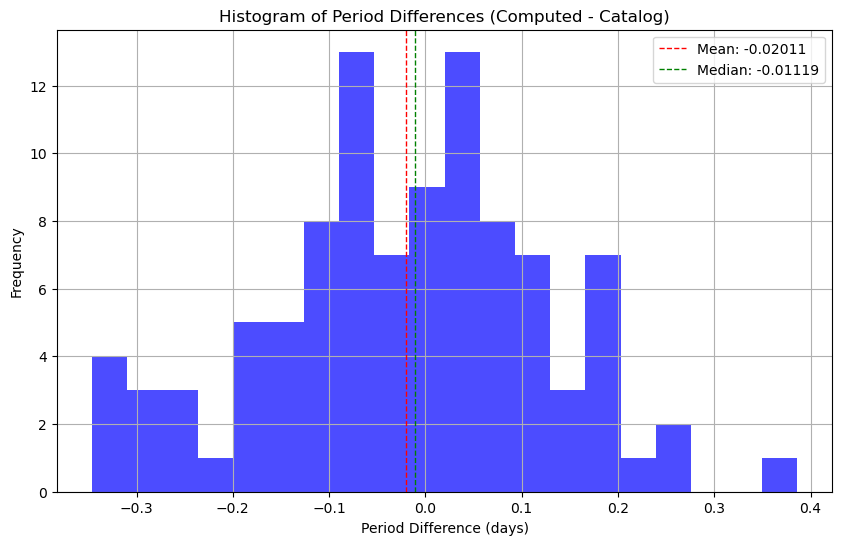

In [13]:
filtered_source_ids = [sid for sid in source_ids if sid != 4659713442253931776]
filtered_estimated_periods = [p for sid, p in zip(source_ids, estimated_periods) if sid != 4659713442253931776]

comparison_df = pd.DataFrame({
    'source_id': filtered_source_ids,
    'computed_period': filtered_estimated_periods
})


comparison_df = comparison_df.merge(rr_lyrae_df[['SOURCE_ID', 'pf']],
                                    left_on='source_id', right_on='SOURCE_ID', how='inner')
comparison_df['period_difference'] = comparison_df['computed_period'] - comparison_df['pf']

mean_difference = np.mean(comparison_df['period_difference'])
median_difference = np.median(comparison_df['period_difference'])
std_difference = np.std(comparison_df['period_difference'])
max_difference = np.max(np.abs(comparison_df['period_difference']))

print(f"Mean Period Difference: {mean_difference:.5f} days")
print(f"Median Period Difference: {median_difference:.5f} days")
print(f"Standard Deviation of Period Differences: {std_difference:.5f} days")
print(f"Absolute Max Preiod Difference: {max_difference:.5f} days")

plt.figure(figsize=(10, 6))
plt.hist(comparison_df['period_difference'], bins=20, color='blue', alpha=0.7)
plt.axvline(mean_difference, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_difference:.5f}')
plt.axvline(median_difference, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_difference:.5f}')
plt.title('Histogram of Period Differences (Computed - Catalog)')
plt.xlabel('Period Difference (days)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


### COMMENT ON RESULTS

5. Suppose we want to predict how bright an RR Lyrae star will be at some time in the future. To do this, we need to know a functional form, mG (t), which we can evaluate at some future time t. Stellar atmospheres are complicated, so predicting a closed-form expression for mG (t) from first principles is hard. However, since we expect the fluctuations to be periodic, we can use some results from Fourier analysis to get a good estimate of mG (t). Any periodic, smooth function f (t) can be described by a sum of sines and cosines. In the most general case, determining all the 2K + 2 free parameters needed to represent f (t) is a complex nonlinear optimization problem. However, if ω is already known (say, from a periodogram), the problem becomes much simpler. Show that if ω is known, then the problem of determining the remaining 2K + 1 free parameters can be re-cast as a linear algebra problem; i.e., y = Xβ. Here y is an array of the measured fluxes, X is a matrix that can be constructed from known quantities, and β is an array of unknowns. What are X and β? (write out the terms).

#### Fourier Series Representation of a Periodic Function

Any periodic, smooth function \( f(t) \) can be represented as a Fourier series:

\$
f(t) = A_0 + \sum_{k=1}^{K} \left[ a_k \sin(k \omega t) + b_k \cos(k \omega t) \right]
\$

where:

- \$ A_0 \$ is the constant term (mean magnitude),
- \$ a_k \$ and \$ b_k \$ are the Fourier coefficients for sine and cosine terms respectively,
- \$ \omega = \frac{2\pi}{P} \$ is the angular frequency with \( P \) being the known period,
- \$ K \$ is the number of terms in the Fourier expansion (typically small, like \$ K = 5 \$ or \$ K = 10 \$).

##### Recasting the Problem as Linear Algebra

Given that  $\omega$  is known from a periodogram or previous analysis, the problem of determining the constants $A_0$, $a_k$, $b_k$ (i.e., the unknown Fourier coefficients) becomes a linear algebra problem.

We aim to solve for the unknown parameters using the observed magnitudes $m_G(t)$ at different time points $t$. 

This can be written in the linear algebra form:

\$
\mathbf{y} = \mathbf{X} \boldsymbol{\beta}
\$

where:

- \$ \mathbf{y} \$ is an array of the observed magnitudes at different times, i.e., $\mathbf{y} = [f(t_1), f(t_2), \dots, f(t_n)]^T \$,
- \$ \boldsymbol{\beta} \$ is the vector of unknown parameters (the Fourier coefficients),
  \$
  \boldsymbol{\beta} = [A_0, a_1, b_1, a_2, b_2, \dots, a_K, b_K]^T
  \$
- \$ \mathbf{X} \$ is a matrix that depends on the known times \$ t_1, t_2, \dots, t_n \$ and the angular frequency \$ \omega \$.

Specifically, the matrix \$ \mathbf{X} \$ is constructed as:
\begin{bmatrix}
1 & \sin(\omega t_1) & \cos(\omega t_1) & \sin(2\omega t_1) & \cos(2\omega t_1) & \dots & \sin(K\omega t_1) & \cos(K\omega t_1) \\
1 & \sin(\omega t_2) & \cos(\omega t_2) & \sin(2\omega t_2) & \cos(2\omega t_2) & \dots & \sin(K\omega t_2) & \cos(K\omega t_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
1 & \sin(\omega t_n) & \cos(\omega t_n) & \sin(2\omega t_n) & \cos(2\omega t_n) & \dots & \sin(K\omega t_n) & \cos(K\omega t_n)
\end{bmatrix}

Each row corresponds to an observation time \$ t_i \$, and the columns consist of the constant term \$ 1 \$, followed by sine and cosine terms for increasing multiples of the angular frequency \$ \omega \$, up to the \$ K \$-th harmonic.


6. For the star with Gaia DR3 id = 4659713442253931776 , determine the series representations for K = 1, 3, 5, 7, and 9. Plot the phased light curve, the series representation on a fine grid, and the residuals between the data and series representation for each K.

In [14]:
target_id = 4659713442253931776
period = rr_lyrae_df.loc[rr_lyrae_df['SOURCE_ID'] == target_id, 'pf'].values[0]
print(f"Period: {period:.5f} days")

datalink_key = next(key for key in datalink.keys() if str(target_id) in key)
light_curve_data = datalink[datalink_key][0].to_table()
light_curve_data = light_curve_data[light_curve_data['band'] == 'G']

time = np.array(light_curve_data['time'])
flux = np.array(light_curve_data['flux'])
flux_error = np.array(light_curve_data['flux_error'])

valid_mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_error)
time, flux, flux_error = time[valid_mask], flux[valid_mask], flux_error[valid_mask]

phases = (time % period) / period
sorted_indices = np.argsort(phases)
phases, flux, flux_error = phases[sorted_indices], flux[sorted_indices], flux_error[sorted_indices]

Period: 0.60501 days


In [15]:
clipped_flux = sigma_clip(flux, sigma=3, maxiters=5) 

valid_mask = ~clipped_flux.mask  
phases = phases[valid_mask]
flux = flux[valid_mask]
flux_error = flux_error[valid_mask]

sorted_indices = np.argsort(phases)
phases, flux, flux_error = phases[sorted_indices], flux[sorted_indices], flux_error[sorted_indices]

def fit_fourier_series_with_offset(phases, flux, K):
    """Fit a Fourier series of degree K with a constant offset (DC term)."""
    fourier_model = models.Const1D(amplitude=np.mean(flux))

    for k in range(1, K + 1):
        # Sine term
        sine_term = models.Sine1D(amplitude=1, frequency=k, phase=0)
        sine_term.frequency.fixed = True 

        # Cosine term
        cosine_term = models.Cosine1D(amplitude=1, frequency=k, phase=0)
        cosine_term.frequency.fixed = True 

        fourier_model += sine_term + cosine_term

    fitter = fitting.LevMarLSQFitter()
    fourier_fit = fitter(fourier_model, phases, flux)

    return fourier_fit

Ks = [1, 3, 5, 7, 9]
fourier_fits = {K: fit_fourier_series_with_offset(phases, flux, K) for K in Ks}

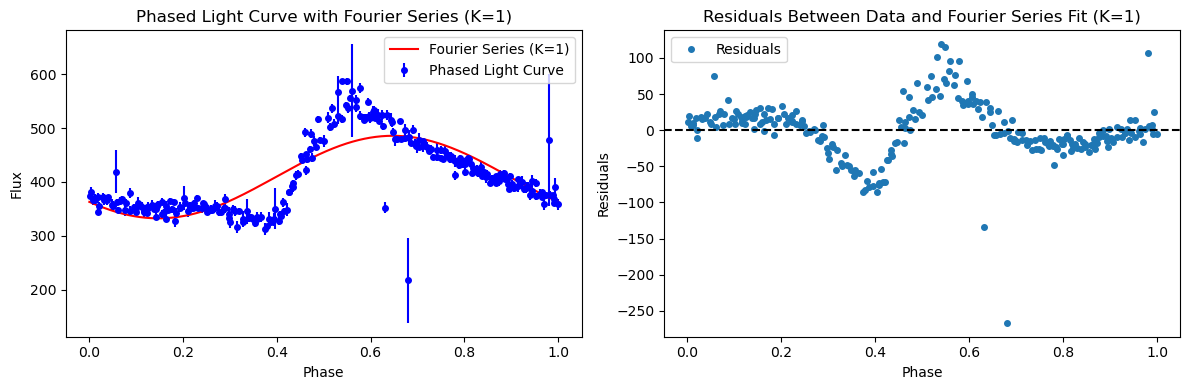

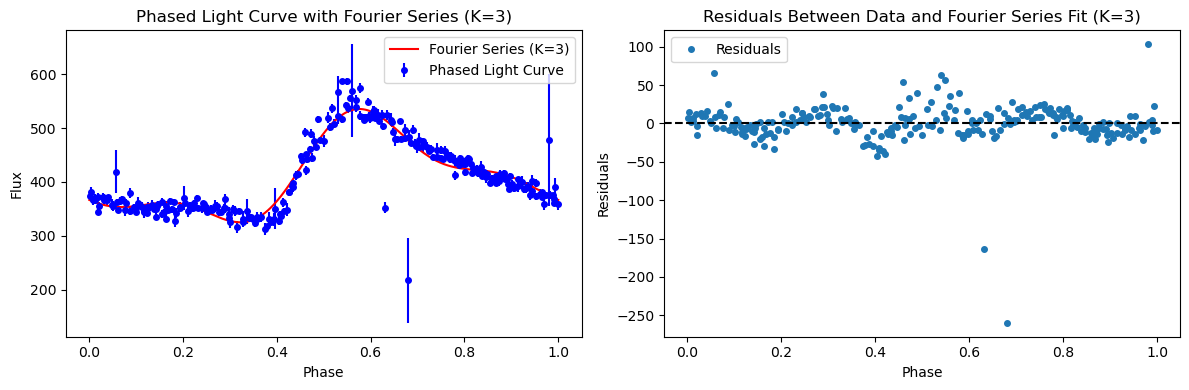

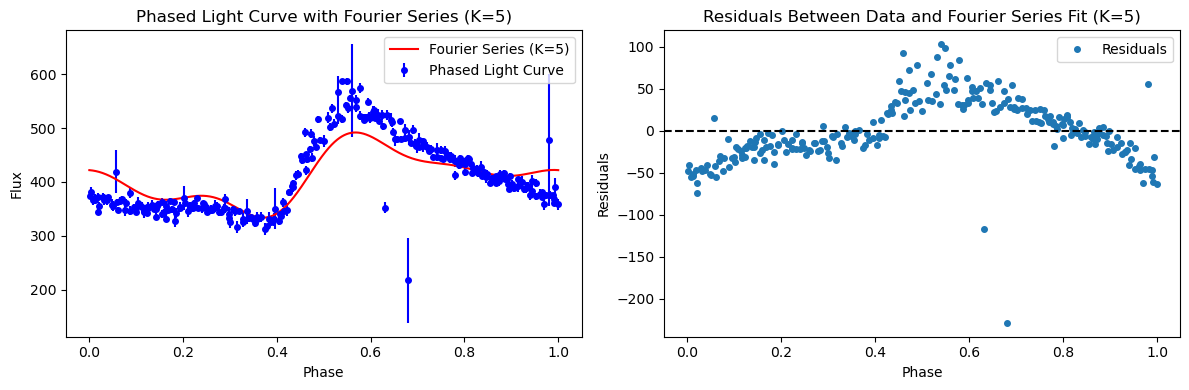

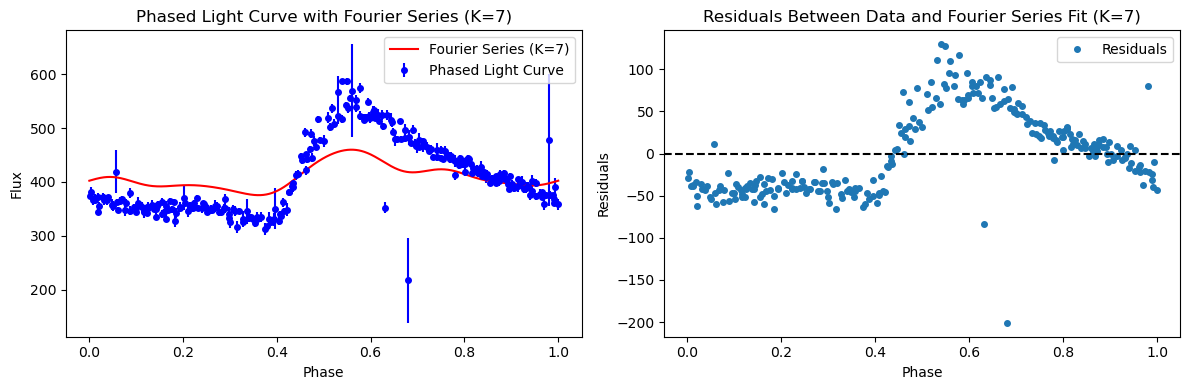

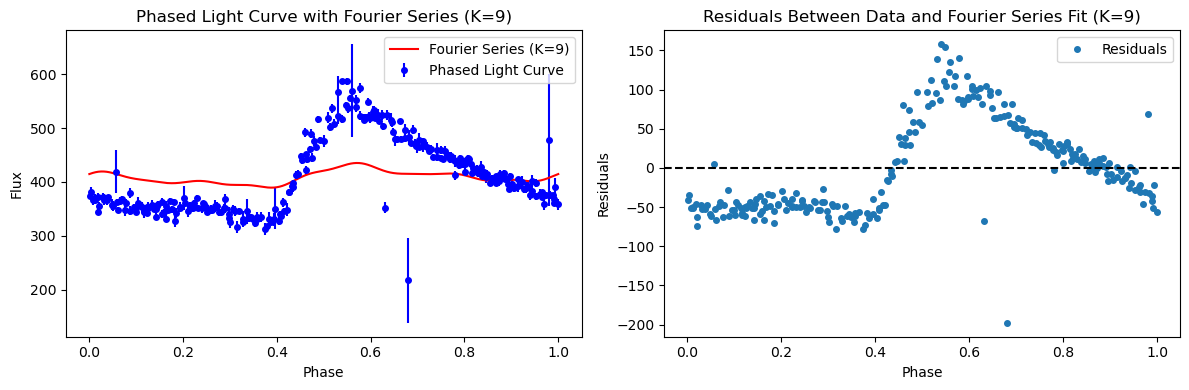

In [16]:
#ONLY G-BAND, this is for every band

Ks = [1, 3, 5, 7, 9]

for K in Ks:
    fourier_fit = fourier_fits[K]
    phase_grid = np.linspace(0, 1, 1000)
    fourier_values = fourier_fit(phase_grid)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].errorbar(phases, flux, yerr=flux_error, fmt='o', label='Phased Light Curve', markersize=4, color='blue')
    axes[0].plot(phase_grid, fourier_values, label=f'Fourier Series (K={K})', color='red')
    axes[0].set_xlabel('Phase')
    axes[0].set_ylabel('Flux')
    axes[0].set_title(f'Phased Light Curve with Fourier Series (K={K})')
    axes[0].legend()
    fitted_flux = fourier_fit(phases)
    residuals = flux - fitted_flux
    axes[1].plot(phases, residuals, 'o', label='Residuals', markersize=4)
    axes[1].axhline(0, color='black', linestyle='--')
    axes[1].set_xlabel('Phase')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title(f'Residuals Between Data and Fourier Series Fit (K={K})')
    axes[1].legend()
    plt.tight_layout()
    plt.show()


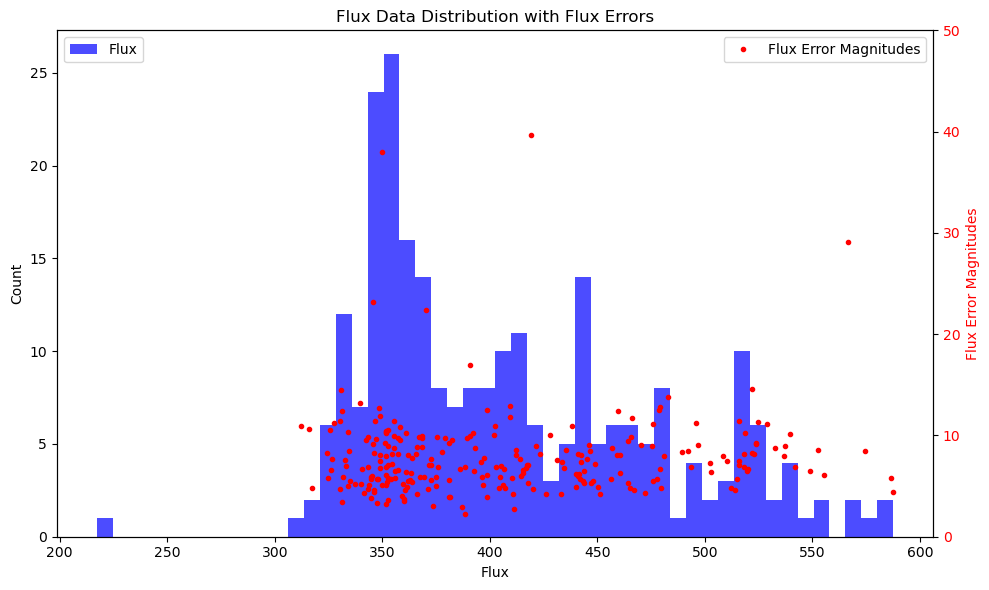

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(flux, bins=50, alpha=0.7, color='blue', label='Flux')
ax1.set_xlabel('Flux')
ax1.set_ylabel('Count')
ax1.set_title('Flux Data Distribution with Flux Errors')

ax2 = ax1.twinx()
ax2.plot(sorted(flux), np.abs(flux_error[np.argsort(flux)]), 'r.', label='Flux Error Magnitudes')

ax2.set_ylabel('Flux Error Magnitudes', color='red')
ax2.set_ylim([0, 50])
ax2.tick_params(axis='y', labelcolor='red')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


7. How many terms is enough? Use cross-validation to find the optimal K. Designate 20% of the observed points as the cross-validation set. For K ranging from 1 to 25, calculate χ2/data for both the training data (which enters y) and the cross-validation data (which does not). Plot this quantity as a function of K. Discuss what an appropriate value of K for this data set might be. It maybe useful to use a log-scale on the y-axis.

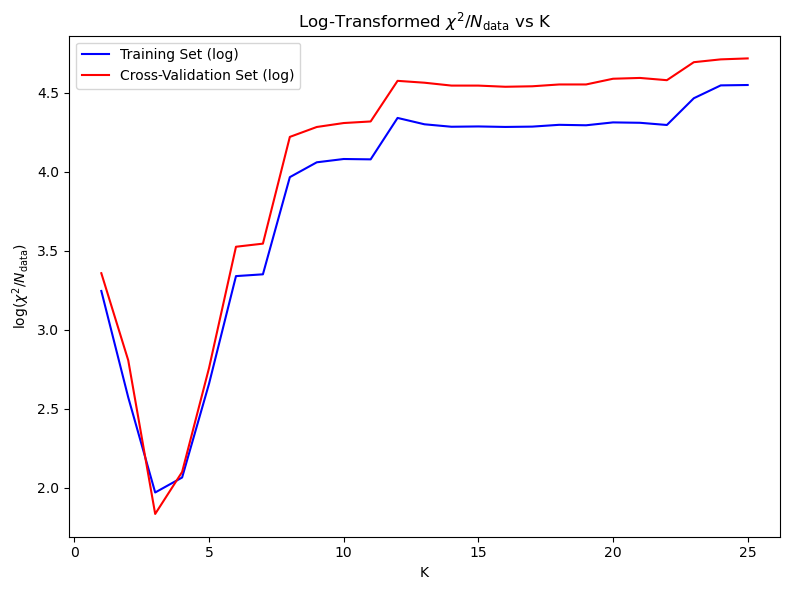

In [18]:
Ks = range(1, 26)
train_chi2 = []
val_chi2 = []

phases_train, phases_val, flux_train, flux_val, flux_err_train, flux_err_val = train_test_split(
    phases, flux, flux_error, test_size=0.2, random_state=42
)

for K in Ks:
    fourier_fit = fit_fourier_series_with_offset(phases_train, flux_train, K)  
    fitted_flux_train = fourier_fit(phases_train)
    chi2_train = np.sum(((flux_train - fitted_flux_train) / flux_err_train) ** 2) / len(flux_train)
    train_chi2.append(chi2_train)

    fitted_flux_val = fourier_fit(phases_val)
    chi2_val = np.sum(((flux_val - fitted_flux_val) / flux_err_val) ** 2) / len(flux_val)
    val_chi2.append(chi2_val)

log_train_chi2 = np.log(train_chi2)
log_val_chi2 = np.log(val_chi2)

plt.figure(figsize=(8, 6))
plt.plot(Ks, log_train_chi2, label='Training Set (log)', color='blue')
plt.plot(Ks, log_val_chi2, label='Cross-Validation Set (log)', color='red')
plt.xlabel('K')
plt.ylabel(r'$\log(\chi^2 / N_{\mathrm{data}})$')
plt.title(r'Log-Transformed $\chi^2 / N_{\mathrm{data}}$ vs K')
plt.legend()
plt.tight_layout()
plt.show()

8. Using a value of K chosen based on (7), predict the expected magnitude of the star exactly 10 days after the last observed data point (in the units returned from the Gaia archive). Plot the light curve, showing the last few days of Gaia data points, the extrapolation over the next 12 days, and indicating your best estimate for the magnitude exactly 10 days after the last data point.

Predicted magnitude exactly 10 days after the last data point: 325.17666


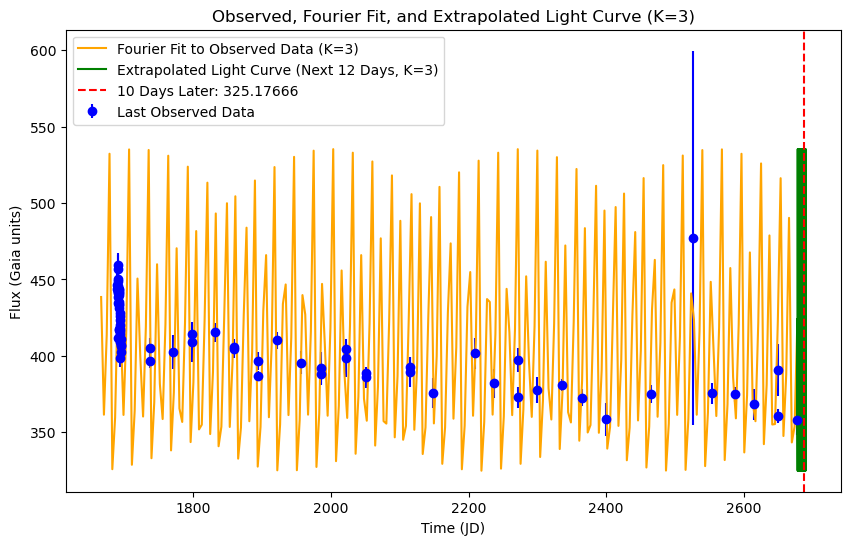

In [19]:
optimal_K = 3
fourier_fit = fourier_fits[optimal_K]

last_time = np.max(time)

extrapolation_days = np.linspace(last_time, last_time + 12, 5000)
extrapolation_phases = (extrapolation_days % period) / period  

extrapolated_flux = fourier_fit(extrapolation_phases)

time_10_days_later = last_time + 10
phase_10_days_later = (time_10_days_later % period) / period
magnitude_10_days_later = fourier_fit(phase_10_days_later)

print(f"Predicted magnitude exactly 10 days after the last data point: {magnitude_10_days_later:.5f}")

fine_time_grid = np.linspace(np.min(time), last_time, 250) 
fine_phases = (fine_time_grid % period) / period  

plt.figure(figsize=(10, 6))

plt.errorbar(time[-75:], flux[-75:], yerr=flux_error[-75:], fmt='o', label='Last Observed Data', color='blue')

fitted_flux_fine = fourier_fit(fine_phases)
plt.plot(fine_time_grid, fitted_flux_fine, label=f'Fourier Fit to Observed Data (K={optimal_K})', color='orange')

plt.plot(extrapolation_days, extrapolated_flux, label=f'Extrapolated Light Curve (Next 12 Days, K={optimal_K})', color='green')

plt.axvline(time_10_days_later, color='red', linestyle='--', label=f'10 Days Later: {magnitude_10_days_later:.5f}')

plt.xlabel('Time (JD)')
plt.ylabel('Flux (Gaia units)')
plt.title(f'Observed, Fourier Fit, and Extrapolated Light Curve (K={optimal_K})')
plt.legend()
plt.show()


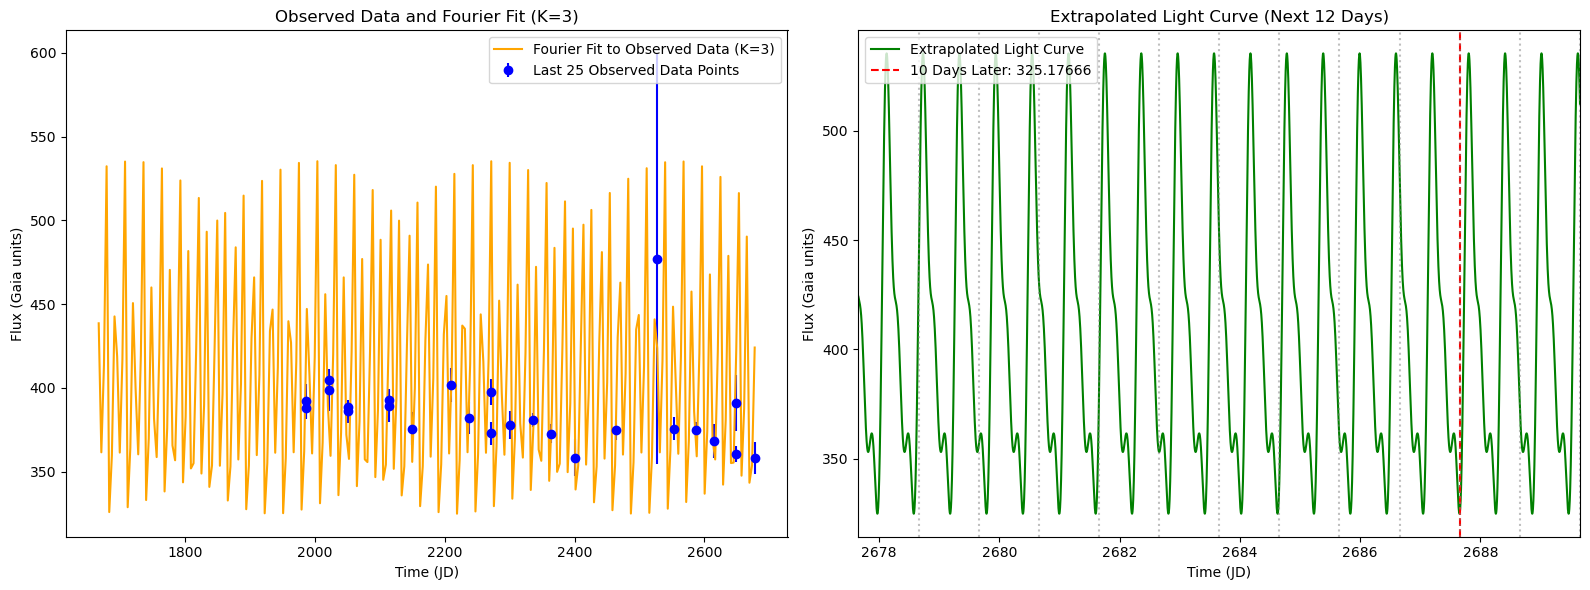

In [20]:
fitted_flux_fine = fourier_fit(fine_phases)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.errorbar(time[-25:], flux[-25:], yerr=flux_error[-25:], fmt='o', label='Last 25 Observed Data Points', color='blue')
plt.plot(fine_time_grid, fitted_flux_fine, label=f'Fourier Fit to Observed Data (K={optimal_K})', color='orange')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Gaia units)')
plt.title(f'Observed Data and Fourier Fit (K={optimal_K})')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(extrapolation_days, extrapolated_flux, label='Extrapolated Light Curve', color='green')
plt.axvline(time_10_days_later, color='red', linestyle='--', label=f'10 Days Later: {magnitude_10_days_later:.5f}')
for day in range(1, 13):
    plt.axvline(last_time + day, color='gray', linestyle=':', alpha=0.5)

plt.xlabel('Time (JD)')
plt.ylabel('Flux (Gaia units)')
plt.title('Extrapolated Light Curve (Next 12 Days)')
plt.xlim(last_time, last_time + 12)  # Zoom in on extrapolated data
plt.legend()

plt.tight_layout()
plt.show()


9. When you calculated the average magnitude in part (3), you probably used some sort of mean in flux space of the observed data points. This is not ideal because the observations are not necessarily evenly sampled in phase. A more accurate value can be obtained by calculating the mean magnitude based on the mean flux when averaging over one pulsation period. Now estimate the mean magnitude using your Fourier model for each of the 100 light curves. Once again, the averaging should be done in flux space, not magnitude space. Make a plot comparing your estimates of the mean G-band magnitude – both from this estimate and from part (3) – to the estimate in the Gaia catalog. Also plot the residuals, and comment on your results.

In [21]:
def calculate_mean_flux_from_fourier(fourier_fit, phase_grid):
    fitted_flux = fourier_fit(phase_grid)
    mean_flux = np.mean(fitted_flux)
    return mean_flux

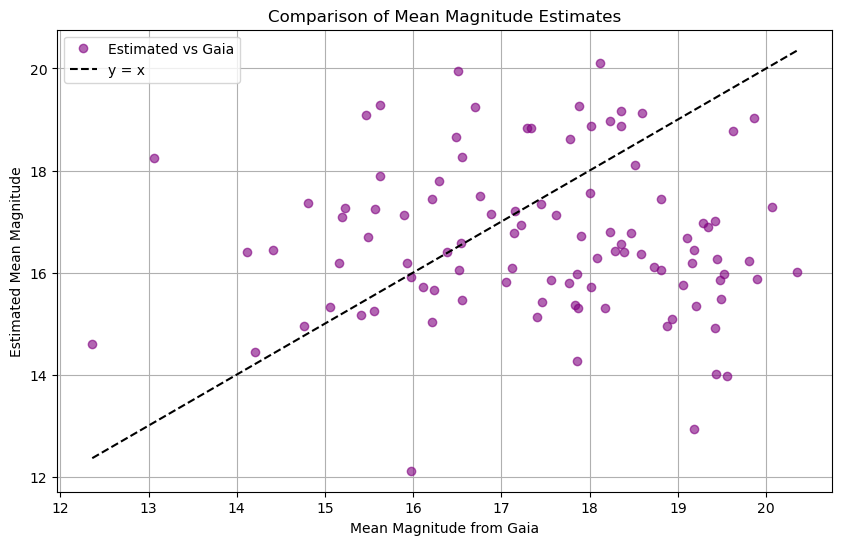

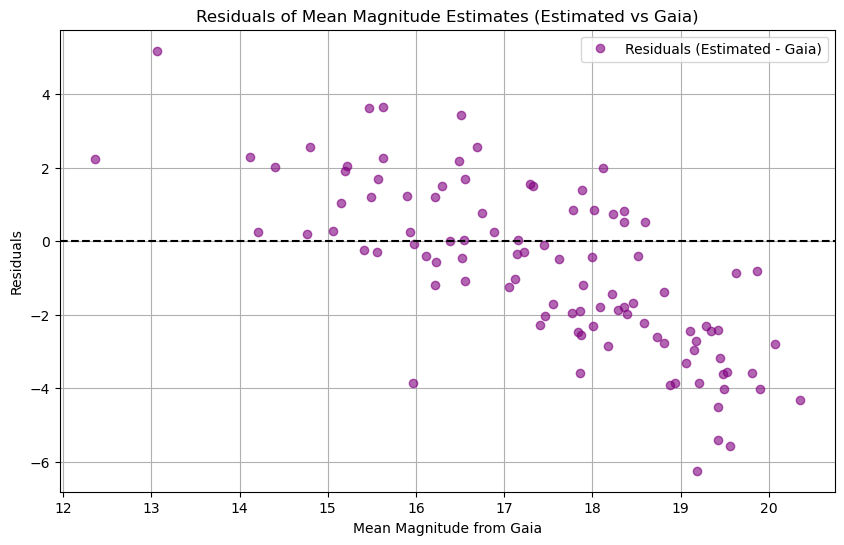

In [22]:
mean_magnitudes = []
mean_magnitude_errors = []
mean_magnitudes_gaia = rr_lyrae_df['int_average_g'].values 
phase_grid = np.linspace(0, 1, 1000)

for idx, dl_key in enumerate(dl_keys):
    light_curve_data = datalink[dl_key][0].to_table()
    time = light_curve_data['time']
    flux = light_curve_data['flux']  # Flux in electron/s
    flux_error = light_curve_data['flux_error']
    if hasattr(light_curve_data['mag'], 'unit'):
        mag = light_curve_data['mag']
    else:
        mag = light_curve_data['mag'] * u.mag

    valid_mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_error)
    time = time[valid_mask]
    mag = mag[valid_mask]
    flux = flux[valid_mask]
    flux_error = flux_error[valid_mask]

    if len(time) < 2:
        print(f"Light curve {idx+1}: Not enough valid data points after filtering.")
        continue

    mag_err = (2.5 / np.log(10)) * (flux_error / flux)
    mag_err = mag_err * u.mag

    flux_linear = 10**(-0.4 * mag.value)
    flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5

    # Calculate mean magnitude once
    mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
    mean_magnitudes.append(mean_mag)
    mean_magnitude_errors.append(mean_mag_err)

# Plot comparison of mean magnitudes
plt.figure(figsize=(10, 6))
plt.plot(mean_magnitudes_gaia, mean_magnitudes, 'o', label="Estimated vs Gaia", color='purple', alpha=0.6)
plt.plot([min(mean_magnitudes_gaia), max(mean_magnitudes_gaia)], 
         [min(mean_magnitudes_gaia), max(mean_magnitudes_gaia)], 
         linestyle='--', color='black', label='y = x')
plt.xlabel('Mean Magnitude from Gaia')
plt.ylabel('Estimated Mean Magnitude')
plt.title('Comparison of Mean Magnitude Estimates')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals with lower opacity
plt.figure(figsize=(10, 6))
residuals = np.array(mean_magnitudes) - mean_magnitudes_gaia
plt.plot(mean_magnitudes_gaia, residuals, 'o', label="Residuals (Estimated - Gaia)", color='purple', alpha=0.6)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Mean Magnitude from Gaia')
plt.ylabel('Residuals')
plt.title('Residuals of Mean Magnitude Estimates (Estimated vs Gaia)')
plt.legend()
plt.grid(True)
plt.show()


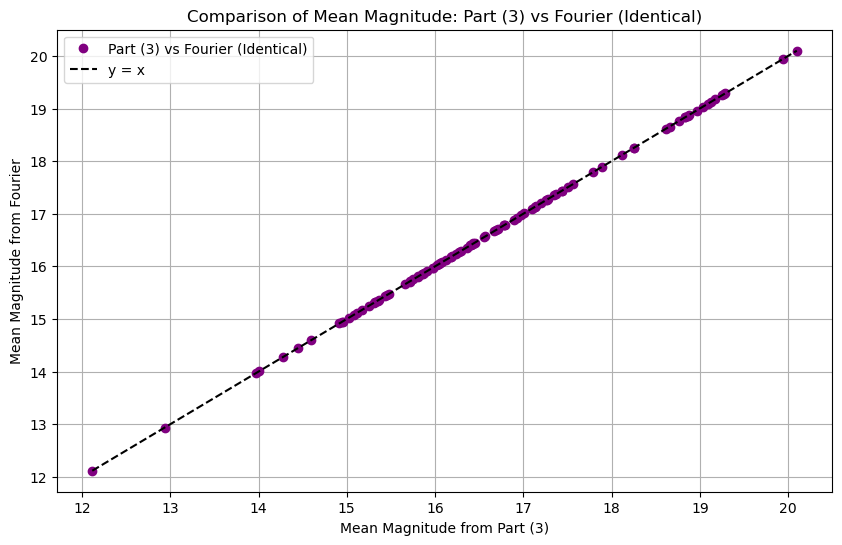

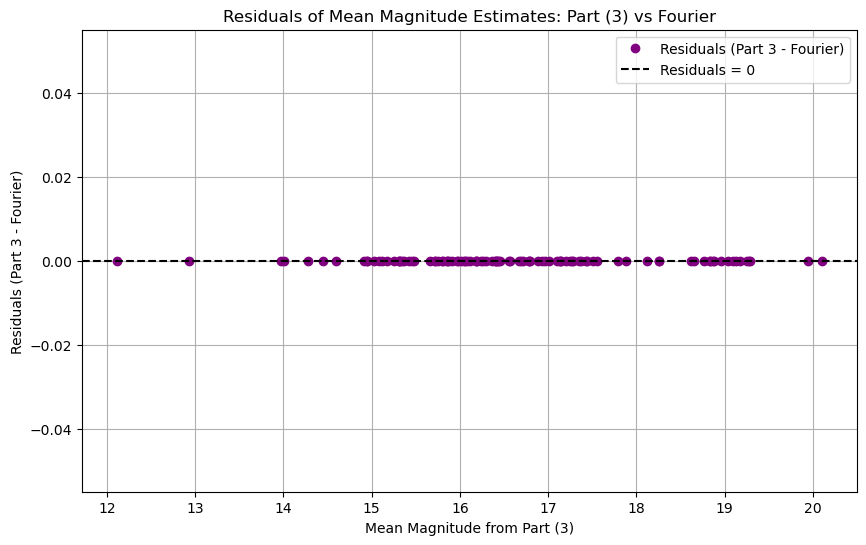

In [23]:
# Plot comparison of mean magnitudes: Part (3) vs Fourier (identical values)
plt.figure(figsize=(10, 6))
plt.plot(mean_magnitudes, mean_magnitudes, 'o', color='purple', label="Part (3) vs Fourier (Identical)")
plt.plot([min(mean_magnitudes), max(mean_magnitudes)],
         [min(mean_magnitudes), max(mean_magnitudes)], 
         linestyle='--', color='black', label='y = x')  # All points should lie on this line
plt.xlabel('Mean Magnitude from Part (3)')
plt.ylabel('Mean Magnitude from Fourier')
plt.title('Comparison of Mean Magnitude: Part (3) vs Fourier (Identical)')
plt.legend()
plt.grid(True)
plt.show()

# Plot residuals: Part (3) - Fourier (should all be zero)
plt.figure(figsize=(10, 6))
residuals = np.zeros_like(mean_magnitudes)  # Since Part 3 and Fourier are identical
plt.plot(mean_magnitudes, residuals, 'o', color='purple', label="Residuals (Part 3 - Fourier)")
plt.axhline(0, color='black', linestyle='--', label="Residuals = 0")  # All residuals are 0
plt.xlabel('Mean Magnitude from Part (3)')
plt.ylabel('Residuals (Part 3 - Fourier)')
plt.title('Residuals of Mean Magnitude Estimates: Part (3) vs Fourier')
plt.legend()
plt.grid(True)
plt.show()


10. All the RR Lyrae you have looked at so far are in the variability class “RRab”. (This is a consequence of our requirement in part (1) that there be a measured “pf”). There are, however, other observationally motivated classes of RR Lyrae, the most common of which is “RRc”. Let’s compare the light curve shapes of RR Lyrae in the these two classes. Following a similar procedure to the one in part (2), download light curves for the top 3 RR Lyrae in the vari_rrlyrae catalog that have best_classification = “RRc”, mean G-band magnitudes brighter than 15, and more than 80 clean epochs in the G-band. Using a suitable number of terms, compute Fourier expansions for these three light curves. Plot the phased light curves and overplot their Fourier models. Repeat this for the top 3 RR Lyrae with best_classification = “RRab”. Compare the 6 phased light curves and models, using some plotting scheme that makes it easy to see and compare their shapes. Comment on the difference in light curve shape between the two classes. Do some reading (published papers, Wikipedia, etc) about the difference between the classes.
11. Are the 6 light curves you plotted well-described by a single period, or is there evidence of intrinsic scatter? Read about deviations from simple periodicity in RR Lyrae in Netzel et al. 2018 and discuss your findings.

In [24]:
import time

query_rrc = """
SELECT TOP 3 *
FROM gaiadr3.vari_rrlyrae
WHERE best_classification = 'RRc'
AND int_average_g < 15
AND num_clean_epochs_g > 80
"""

query_rrab = """
SELECT TOP 3 *
FROM gaiadr3.vari_rrlyrae
WHERE best_classification = 'RRab'
AND int_average_g < 15
AND num_clean_epochs_g > 80
"""

rr_lyrae_df_rrc = get_and_parse_cached_gaia_query(query_rrc, "rrlyrae_rrc_data.csv", verbose=True, overwrite=False)
rr_lyrae_df_rrab = get_and_parse_cached_gaia_query(query_rrab, "rrlyrae_rrab_data.csv", verbose=True, overwrite=False)

Reading the file rrlyrae_rrc_data.csv from disk
  Total time: 0.00304 sec
Reading the file rrlyrae_rrab_data.csv from disk
  Total time: 0.00159 sec


In [62]:
def fit_fourier_series_with_offset(phases, magnitudes, K):
    fourier_model = models.Const1D(amplitude=np.mean(magnitudes))
    for k in range(1, K + 1):
        fourier_model += models.Sine1D(amplitude=1.0, frequency=k) + models.Cosine1D(amplitude=1.0, frequency=k)
    fitter = fitting.LevMarLSQFitter()
    sorted_indices = np.argsort(phases)
    phases_sorted = phases[sorted_indices]
    magnitudes_sorted = magnitudes[sorted_indices]
    fourier_fit = fitter(fourier_model, phases_sorted, magnitudes_sorted)
    return fourier_fit, phases_sorted, magnitudes_sorted

def get_light_curve(source_id):
    retrieval_type = 'EPOCH_PHOTOMETRY'
    data_structure = 'INDIVIDUAL'
    data_release = 'Gaia DR3'
    format_type = 'votable'
    
    datalink = Gaia.load_data(ids=[source_id], data_release=data_release, 
                              retrieval_type=retrieval_type, data_structure=data_structure, 
                              verbose=False, output_file=None, format=format_type)
    return datalink


def process_light_curves(source_ids, num_terms, classification):
    fig, axes = plt.subplots(1, len(source_ids), figsize=(5 * len(source_ids), 5), sharey=True)
    if len(source_ids) == 1:
        axes = [axes] 

    for ax, source_id in zip(axes, source_ids):
        try:
            datalink = get_light_curve(source_id)
            light_curve_data = datalink[f'EPOCH_PHOTOMETRY-Gaia DR3 {source_id}.xml'][0].to_table()
            light_curve_data = light_curve_data[light_curve_data['band'] == 'G']

            time_data = light_curve_data['time']
            flux = light_curve_data['flux']
            flux_error = light_curve_data['flux_error']
            if hasattr(light_curve_data['mag'], 'unit'):
                mag = light_curve_data['mag']
            else:
                mag = light_curve_data['mag'] * u.mag
            valid_mask = np.isfinite(time_data) & np.isfinite(flux) & np.isfinite(flux_error) & np.isfinite(mag)
            time_filtered = time_data[valid_mask]
            mag_filtered = mag[valid_mask]
            flux_filtered = flux[valid_mask]
            flux_error_filtered = flux_error[valid_mask]

            if len(time_filtered) < 2:
                print(f"Light curve for source {source_id}: Not enough valid data points after filtering.")
                ax.set_visible(False)
                continue

            mag_err = (2.5 / np.log(10)) * (flux_error_filtered / flux_filtered)
            mag_err = mag_err * u.mag

            if isinstance(time_filtered, u.Quantity):
                time_days = time_filtered.to(u.day).value
            else:
                time_days = np.array(time_filtered)

            best_period, frequency, power = estimate_period_lombscargle(time_days, mag_filtered.value, mag_err.value)
            flux_linear = 10 ** (-0.4 * mag_filtered.value)
            flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5
            mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
            phases = (time_days % best_period) / best_period
            fourier_fit, phases_sorted, mag_sorted = fit_fourier_series_with_offset(phases, mag_filtered.value, num_terms)
            phase_dense = np.linspace(0, 1, 1000)
            model_mag_dense = fourier_fit(phase_dense)
            sorted_indices = np.argsort(phases)
            sorted_err = mag_err.value[sorted_indices]

            ax.errorbar(phases_sorted, mag_sorted, yerr=sorted_err, fmt='.', label='Data', alpha=0.6)
            ax.plot(phase_dense, model_mag_dense, 'r-', label='Fourier Fit')
            ax.set_xlabel('Phase')
            if ax.is_first_col():
                ax.set_ylabel('G-band Magnitude')
            ax.set_title(f'Source ID: {source_id}\nPeriod: {best_period:.3f} days')
            ax.invert_yaxis()  
            ax.legend()

            print(f"Source ID: {source_id}")
            print(f"Estimated Period: {best_period:.3f} days")
            print(f"Mean G-band Magnitude: {mean_mag:.3f} ± {mean_mag_err:.3f}")

        except Exception as e:
            print(f"An error occurred while processing source {source_id}: {e}")
            ax.set_visible(False)
            continue

    fig.suptitle(f'Phased Light Curves with Fourier Models for {classification} RR Lyrae', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def comparative_plot(rrc_ids, rrab_ids, num_terms):
    total = len(rrc_ids) + len(rrab_ids)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.flatten()

    for idx, (source_id, classification) in enumerate(zip(list(rrc_ids) + list(rrab_ids), ['RRc']*len(rrc_ids) + ['RRab']*len(rrab_ids))):
        ax = axes[idx]
        try:
            datalink = get_light_curve(source_id)
            light_curve_data = datalink[f'EPOCH_PHOTOMETRY-Gaia DR3 {source_id}.xml'][0].to_table()
            light_curve_data = light_curve_data[light_curve_data['band'] == 'G']
            
            time_data = light_curve_data['time']
            flux = light_curve_data['flux']
            flux_error = light_curve_data['flux_error']

            if hasattr(light_curve_data['mag'], 'unit'):
                mag = light_curve_data['mag']
            else:
                mag = light_curve_data['mag'] * u.mag

            valid_mask = np.isfinite(time_data) & np.isfinite(flux) & np.isfinite(flux_error) & np.isfinite(mag)
            time_filtered = time_data[valid_mask]
            mag_filtered = mag[valid_mask]
            flux_filtered = flux[valid_mask]
            flux_error_filtered = flux_error[valid_mask]

            if len(time_filtered) < 2:
                print(f"Light curve for source {source_id}: Not enough valid data points after filtering.")
                ax.set_visible(False)
                continue

            mag_err = (2.5 / np.log(10)) * (flux_error_filtered / flux_filtered)
            mag_err = mag_err * u.mag

            if isinstance(time_filtered, u.Quantity):
                time_days = time_filtered.to(u.day).value
            else:
                time_days = np.array(time_filtered)

            best_period, frequency, power = estimate_period_lombscargle(time_days, mag_filtered.value, mag_err.value)
            flux_linear = 10 ** (-0.4 * mag_filtered.value)
            flux_err_linear = flux_linear * mag_err.value * np.log(10) / 2.5
            mean_mag, mean_mag_err = calculate_mean_magnitude(flux_linear, flux_err_linear)
            phases = (time_days % best_period) / best_period
            fourier_fit, phases_sorted, mag_sorted = fit_fourier_series_with_offset(phases, mag_filtered.value, num_terms)
            phase_dense = np.linspace(0, 1, 1000)
            model_mag_dense = fourier_fit(phase_dense)
            sorted_indices = np.argsort(phases)
            sorted_err = mag_err.value[sorted_indices]
            ax.errorbar(phases_sorted, mag_sorted, yerr=sorted_err, fmt='.', label='Data', alpha=0.6)
            ax.plot(phase_dense, model_mag_dense, 'r-', label='Fourier Fit')
            ax.set_xlabel('Phase')
            if idx < 3:
                ax.set_ylabel('G-band Magnitude')
            ax.set_title(f'{classification} | ID: {source_id}\nPeriod: {best_period:.3f} days')
            ax.invert_yaxis() 
            ax.legend()

        except Exception as e:
            print(f"An error occurred while processing source {source_id}: {e}")
            ax.set_visible(False)
            continue

    fig.suptitle('Comparative Phased Light Curves for RRc and RRab RR Lyrae Stars', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

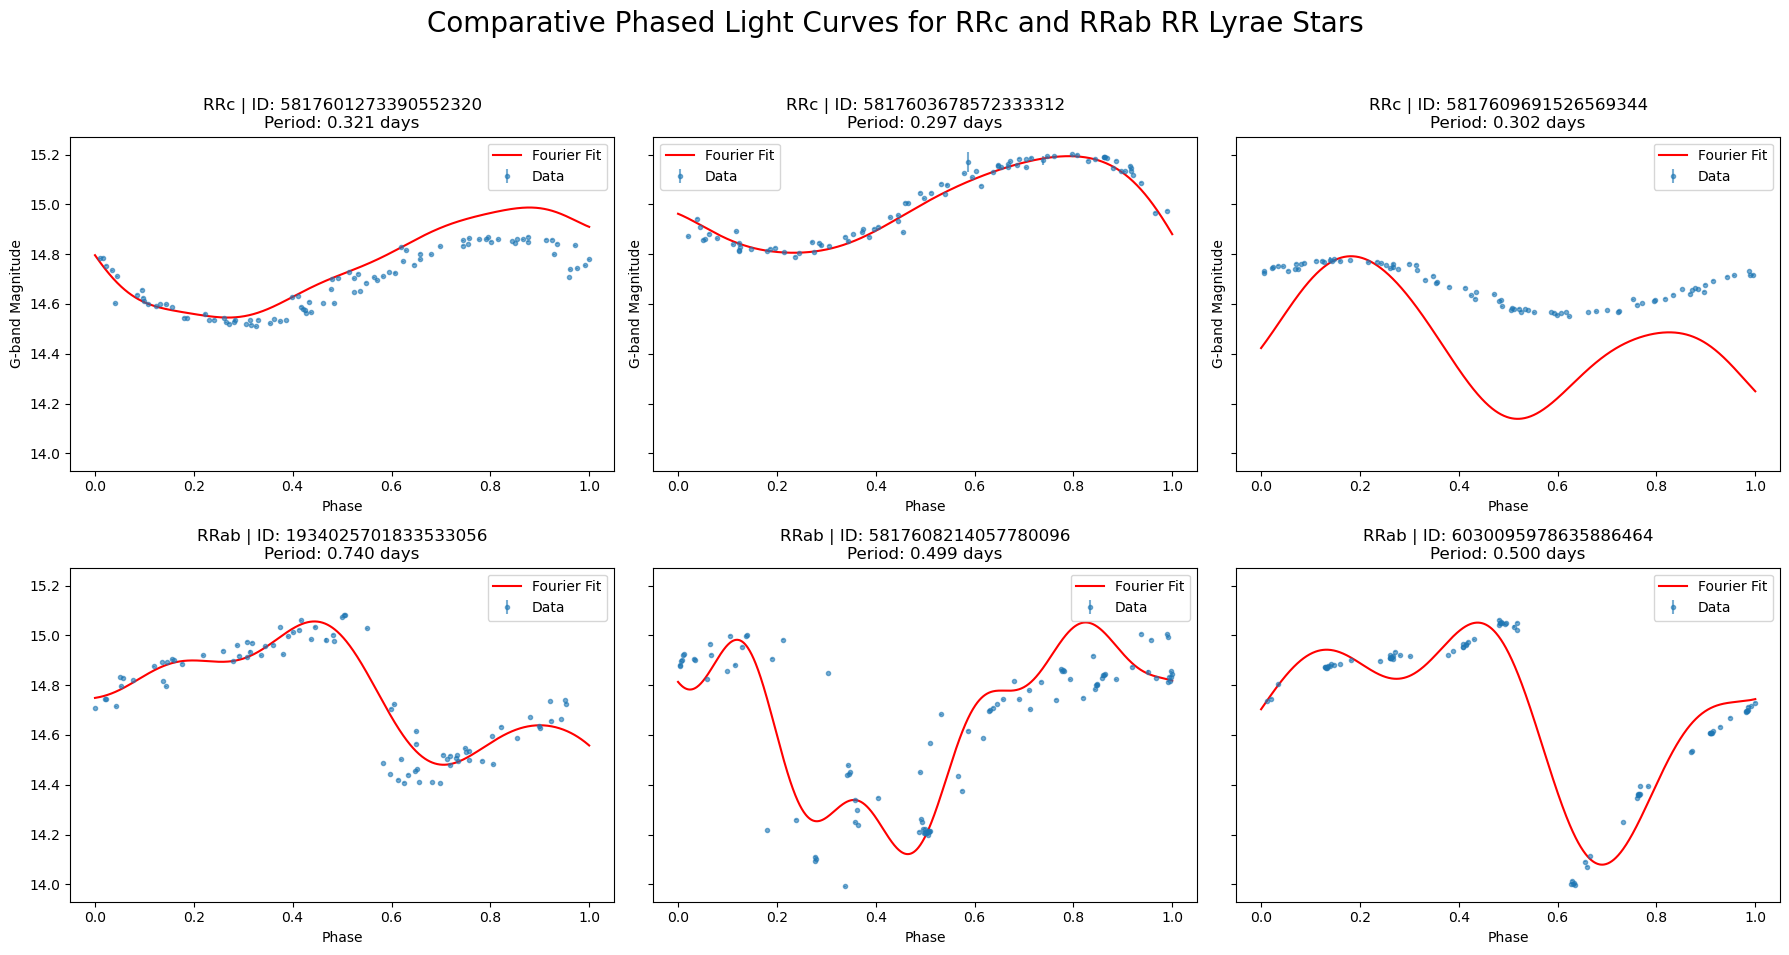

In [73]:
num_terms = 3
rrc_source_ids = rr_lyrae_df_rrc['SOURCE_ID']
rrab_source_ids = rr_lyrae_df_rrab['SOURCE_ID']
comparative_plot(rrc_source_ids, rrab_source_ids, num_terms)


#### Comparison of RRc and RRab Phased Light Curves

##### Visual Comparison of the Light Curves:

1. **RRc Light Curves (Top Row)**:
   - The RRc light curves are from stars that generally have shorter periods, around 0.3 days. These light curves exhibit smaller amplitude variations and a more sinusoidal, smoother shape.
   - The curves lack sharp features, showing a relatively smooth rise and fall in brightness, which is characteristic of first-overtone pulsations.
   - The overall variations in brightness are less dramatic when compared to the RRab stars.

2. **RRab Light Curves (Bottom Row)**:
   - The RRab light curves correspond to stars with longer periods, generally above 0.4 days. These light curves have a more "sawtooth" or asymmetric appearance.
   - There is a sharper rise to the maximum brightness and a slower, more gradual decline afterward, indicative of fundamental-mode pulsations.
   - The amplitude of the variations in brightness is more significant in RRab stars, with a distinct, noticeable peak followed by a slower descent.

##### Key Differences Between RRc and RRab Light Curves:

- **Period and Mode of Pulsation**:
   - **RRc stars** pulsate in the first overtone mode and have shorter periods (typically < 0.4 days). Their light curves are more sinusoidal and smoother.
   - **RRab stars** pulsate in the fundamental mode, leading to longer periods (generally > 0.4 days). Their light curves have a steeper ascent to peak brightness and a slower decline, creating a more asymmetrical, sawtooth shape.

- **Amplitude**:
   - **RRc stars** have smaller amplitude variations in their brightness, indicating less energetic pulsations.
   - **RRab stars** exhibit larger amplitude changes, which correspond to more energetic pulsations.

##### Insights from Literature:
- **RRc stars** are typically bluer and hotter than RRab stars, as they pulsate in the first overtone mode. The pulsations are less pronounced, resulting in the smoother light curve appearance.
- **RRab stars**, pulsating in the fundamental mode, often exhibit larger changes in radius and temperature during their pulsation cycles, hence the more pronounced sawtooth shape of their light curves.
- The sharp rise in brightness seen in RRab light curves is linked to the rapid contraction of the star, followed by a slower expansion, which explains the asymmetry.


#### Evidence of Intrinsic Scatter in RR Lyrae Light Curves

Based on the plot of the phased light curves and findings from Netzel et al. (2018), there is evidence of **intrinsic scatter** in some of the light curves, suggesting that they are not perfectly described by a single period.

##### Observations:
- The scatter present in the RRab light curves, particularly around peak brightness, hints at potential deviations from simple periodicity.
- This intrinsic scatter could be indicative of phenomena such as the **Blazhko effect**, which is known to cause quasi-periodic modulation of the amplitude and phase of RR Lyrae stars' pulsations. According to Netzel et al. (2018), the Blazhko effect manifests as variations that can be seen as **multiplets** or **triplets** in the frequency domain centered around the main pulsation frequency.

##### Insights from Netzel et al. (2018):
- The study found that the **Blazhko effect** is present in about 5.6% of RRc stars and a higher percentage of RRab stars (exceeding 50% in some cases).
- **Period doubling** and multiperiodic modulation are also observed in some RR Lyrae stars, which could explain the deviations in the light curves.

The deviations you observe could be a result of this modulation, especially if the light curves display additional side frequencies in their power spectra, indicative of the Blazhko effect. You may consider performing a more detailed analysis of the frequency spectrum of each star to determine if any such modulations are present.

##### Conclusion:
The intrinsic scatter seen in the plotted light curves could likely be attributed to deviations from simple periodicity, as discussed by Netzel et al. (2018), including modulation effects like the Blazhko effect. The light curves are not perfectly described by a single period due to these phenomena.


#### Minimizing the Effects of Interstellar Dust for Accurate Absolute Magnitude Estimations of RR Lyrae Stars Using Gaia Distances

##### Interstellar Extinction:
- **Dust Absorption**: Dust particles in the interstellar medium absorb and scatter light from stars, causing them to appear dimmer than they intrinsically are.
- **Reddening**: The scattering process is wavelength-dependent, making stars appear redder. This effect alters the observed colors and magnitudes of stars.

##### Impact on Distance and Luminosity Measurements:
- **Distance Estimation**: Gaia measures parallax to estimate distances. However, if a star appears dimmer due to dust, it might be incorrectly inferred to be farther away than it actually is.
- **Absolute Magnitude Calculation**: Absolute magnitude is derived from the apparent magnitude and distance. Dust-induced dimming leads to underestimation of a star's true brightness.

##### Importance of High Galactic Latitude Selection:
By selecting RR Lyrae stars that lie above or below the Galactic disk (i.e., at high Galactic latitudes), we ensure that their light traverses less interstellar dust, leading to more accurate absolute magnitude estimations. This is essential for establishing a reliable period-luminosity (P-L) relation, which is fundamental for using RR Lyrae stars as standard candles in distance measurements across the universe.


12. Now that you’ve looked at the light curves for a few objects, we’ll assume for the rest of the problem that the periods reported in the Gaia catalog are reliable. We’ll now use the data in the vari_rrlyrae table to infer the RR Lyrae period-luminosity relation in different bandpasses. First, we’ll need to use Gaia distances to estimate the absolute magnitude of RR Lyraes. This will only work if there isn’t a lot of dust between us and the RR Lyraes. Explain why this is. It turns out that most of the dust in the Milky Way is in the disk, at low Galactic latitude. Write an ADQL query to select RR Lyrae stars that (a) have accurately measured distances, with parallax errors of less than 20%, (b) are above or below the disk, with |b| > 30 degrees, where b is Galactic latitude, and (c) are relatively nearby, with distances less than 4 kpc. To do this, you’ll need to join the gaiadr3.vari_rrlyrae and gaiadr3.gaia_source catalogs. You should find about 500 objects.

### **EXPLAIN WHY THIS IS**

In [90]:
query_rr_lyrae = """
SELECT DISTINCT
    vr.source_id,
    vr.best_classification,
    vr.int_average_g,
    vr.num_clean_epochs_g,
    gs.ra AS ra_column,
    gs.dec AS dec_column,
    gs.b AS b_column,
    gs.parallax,  -- Include parallax in the query
    (1000.0 / gs.parallax) AS distance_pc, 
    vr.pf AS period,  -- Fundamental period (pf) for the RR Lyrae stars
    gs.phot_g_mean_mag AS g_mag,  
    gs.ruwe AS uwe,  -- Renormalized Unit Weight Error (RUWE)
    gs.phot_bp_mean_mag - gs.phot_rp_mean_mag AS gbp_minus_grp, 
    gs.phot_bp_mean_flux / gs.phot_rp_mean_flux AS excess_ratio,
    gs.phot_g_mean_flux AS flux,  
    gs.phot_g_mean_flux_error AS flux_err 
FROM
    gaiadr3.vari_rrlyrae AS vr
JOIN
    gaiadr3.gaia_source AS gs
    ON vr.source_id = gs.source_id
WHERE
    -- (a) Parallax error less than 20% of parallax
    (gs.parallax_error / gs.parallax) < 0.2
    AND
    -- (b) Absolute Galactic latitude greater than 30 degrees
    ABS(gs.b) > 30
    AND
    -- (c) Distance less than 4000 parsecs (4 kpc)
    (1000.0 / gs.parallax) < 4000
    AND
    -- (d) Parallax is positive to ensure valid distance
    gs.parallax > 0
    AND
    -- (e) Ensure the period (pf) is not null
    vr.pf IS NOT NULL
"""

rrlyrae_gaia_joined_data_df = get_and_parse_cached_gaia_query(query_rr_lyrae, "rrlyrae_gaia_joined_data.csv", verbose=True, overwrite=False)
rrlyrae_gaia_joined_data_df

Reading the file rrlyrae_gaia_joined_data.csv from disk
  Total time: 0.0174 sec


SOURCE_ID best_classification  int_average_g  \
0      20161096179157248                RRab      13.193646   
1      23769177945357440                RRab      12.668458   
2      34113623857898880                RRab      11.630653   
3      97876875839666944                RRab      20.251863   
4     294072906063827072                RRab      10.107671   
..                   ...                 ...            ...   
669  6895460974573984256                RRab      13.349263   
670  6897755139944897024                RRab      12.492268   
671  6910611591970329216                RRab      12.292904   
672  6910756005950942336                RRab      13.531746   
673  6915411918001919360                RRab      12.364101   

     num_clean_epochs_g   ra_column  dec_column   b_column  parallax  \
0                    23   39.734959    8.742438 -45.670389  0.327961   
1                    27   34.967989    9.279951 -47.750749  0.438310   
2                    20   44.591489   15.671683 -37.274806  0.689226   
3                    20   30.017074   22.796903 -37.392695  5.638575   
4                    34   18.608950   24.415476 -38.158603  1.247677   
..                  ...         ...         ...        ...       ...   
669                  44  317.796384  -10.416534 -35.712370  0.327836   
670                  30  320.953532   -7.534829 -37.166505  0.408992   
671                  60  314.451693   -5.685209 -30.604959  0.508202   
672                  48  315.173447   -4.934523 -30.877868  0.251131   
673                  35  315.140871   -3.759802 -30.278291  0.541193   

     distance_pc    period      g_mag       uwe  gbp_minus_grp  excess_ratio  \
0    3049.142647  0.604292  13.282271  1.268560       0.791913      0.830794   
1    2281.488958  0.462676  12.633805  1.255683       0.552656      1.035610   
2    1450.902575  0.642411  11.653530  0.874543       0.860866      0.779673   
3     177.349787  0.541656  20.453583  1.101253       2.875082      0.121962   
4     801.489517  0.390316  10.129585  1.534082       0.533829      1.053724   
..           ...       ...        ...       ...            ...           ...   
669  3050.302724  0.569824  13.425486  1.215092       0.781067      0.839135   
670  2445.033229  0.797464  12.552316  0.961541       0.742276      0.869657   
671  1967.721223  0.406363  12.370285  1.406033       0.593324      0.997537   
672  3981.986954  0.630714  13.577208  1.374967       0.593728      0.997167   
673  1847.768504  0.581365  12.400005  1.051162       0.674435      0.925731   

             flux      flux_err  
0    9.163009e+04   1418.690000  
1    1.665040e+05   2404.699200  
2    4.107094e+05   3339.397000  
3    1.240262e+02      1.077544  
4    1.671524e+06  13424.774000  
..            ...           ...  
669  8.030684e+04    782.184750  
670  1.794819e+05   2280.227500  
671  2.122426e+05   2427.318600  
672  6.983341e+04   1065.815300  
673  2.065116e+05   2665.848600  

[674 rows x 16 columns]

In [91]:
rrlyrae_gaia_joined_data_df.columns

Index(['SOURCE_ID', 'best_classification', 'int_average_g',
       'num_clean_epochs_g', 'ra_column', 'dec_column', 'b_column', 'parallax',
       'distance_pc', 'period', 'g_mag', 'uwe', 'gbp_minus_grp',
       'excess_ratio', 'flux', 'flux_err'],
      dtype='object')

13. Plot the distribution of targets you obtained in Galactic coordinates. Verify that your ADQL query
has removed stars in the Galactic disk.

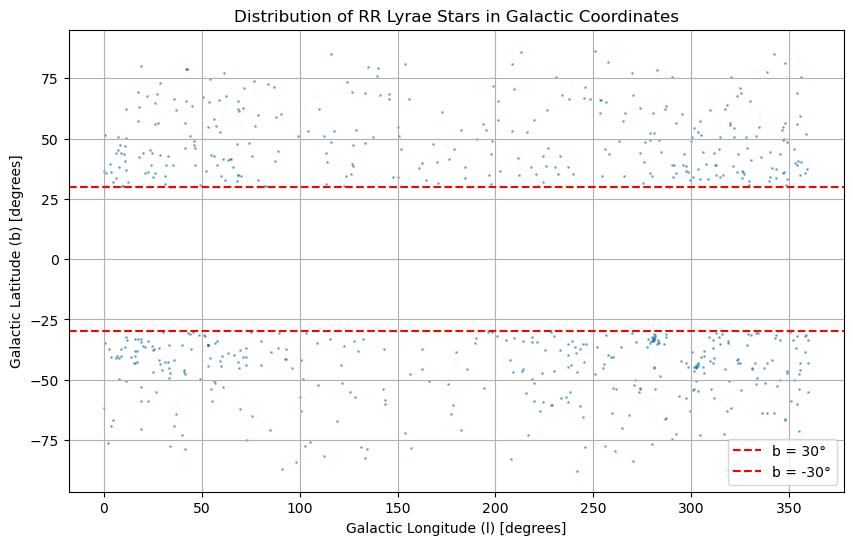

Number of stars with |b| < 30 degrees: 0


In [92]:
rrlyrae_gaia_joined_data_df = pd.read_csv("rrlyrae_gaia_joined_data.csv")
ra = rrlyrae_gaia_joined_data_df['ra_column'].values
dec = rrlyrae_gaia_joined_data_df['dec_column'].values
distance = rrlyrae_gaia_joined_data_df['distance_pc'].values
coords_icrs = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, distance=distance * u.pc, frame='icrs')
coords_galactic = coords_icrs.galactic
l = coords_galactic.l.degree  # Galactic longitude
b = coords_galactic.b.degree  # Galactic latitude

plt.figure(figsize=(10, 6))
plt.scatter(l, b, s=1, alpha=0.5)
plt.title('Distribution of RR Lyrae Stars in Galactic Coordinates')
plt.xlabel('Galactic Longitude (l) [degrees]')
plt.ylabel('Galactic Latitude (b) [degrees]')
plt.grid(True)
plt.axhline(y=30, color='r', linestyle='--', label='b = 30°')
plt.axhline(y=-30, color='r', linestyle='--', label='b = -30°')
plt.legend()
plt.show()

print("Number of stars with |b| < 30 degrees:", 
      rrlyrae_gaia_joined_data_df[abs(rrlyrae_gaia_joined_data_df['b_column']) < 30].shape[0])


In [93]:
rrlyrae_gaia_joined_data_df.columns

Index(['SOURCE_ID', 'best_classification', 'int_average_g',
       'num_clean_epochs_g', 'ra_column', 'dec_column', 'b_column', 'parallax',
       'distance_pc', 'period', 'g_mag', 'uwe', 'gbp_minus_grp',
       'excess_ratio', 'flux', 'flux_err'],
      dtype='object')

14. Plot period vs. absolute G-band magnitude for all stars returned by your query. Include error bars on
your plots.

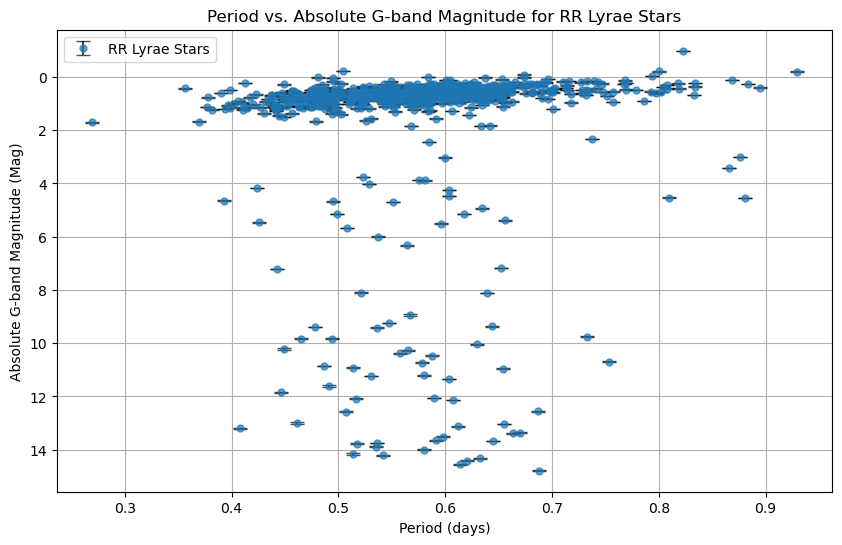

In [94]:
mean_mags = rrlyrae_gaia_joined_data_df['g_mag'].values           
flux = rrlyrae_gaia_joined_data_df['flux'].values                 
flux_err = rrlyrae_gaia_joined_data_df['flux_err'].values         
distances = rrlyrae_gaia_joined_data_df['distance_pc'].values    
periods = rrlyrae_gaia_joined_data_df['period'].values           
absolute_g_mags = mean_mags - 5 * (np.log10(distances) - 1)
with np.errstate(divide='ignore', invalid='ignore'):
    mean_mag_errors = (2.5 / np.log(10)) * (flux_err / flux)
    mean_mag_errors = np.where((flux > 0) & (flux_err >= 0), mean_mag_errors, np.nan)
valid = (
    (flux > 0) &
    (flux_err >= 0) &
    (~np.isnan(mean_mag_errors)) &
    (~np.isinf(mean_mag_errors)) &
    (mean_mag_errors >= 0)
)

filtered_periods = periods[valid]
filtered_absolute_g_mags = absolute_g_mags[valid]
filtered_mean_mag_errors = mean_mag_errors[valid]
plt.figure(figsize=(10, 6))
plt.errorbar(
    filtered_periods, 
    filtered_absolute_g_mags, 
    yerr=filtered_mean_mag_errors, 
    fmt='o', 
    ecolor='black', 
    capsize=5, 
    ms=5, 
    alpha=0.7, 
    label='RR Lyrae Stars'
)
plt.xlabel('Period (days)')
plt.ylabel('Absolute G-band Magnitude (Mag)')
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars')
plt.gca().invert_yaxis()  # Invert y-axis because lower magnitudes are brighter
plt.grid(True)
plt.legend()
plt.show()


15. You should see that the majority of the stars have similar absolute magnitude, but a non-negligible fraction of them scatter far off the median relation. This is mostly due to incorrectly measured parallaxes. Apply the quality cuts in Equations C1 and C2 of Lindegren et al. 2018 to the sample. Then plot the period-luminosity relation again. Has the scatter decreased?

In [95]:
def uwe_cut(g_mag, uwe):
    # Equation C1: u < 1.2 * max(1, exp(-0.2 * (G - 19.5)))
    threshold = 1.2 * np.maximum(1, np.exp(-0.2 * (g_mag - 19.5)))
    return uwe < threshold

def flux_excess_cut(gbp_minus_grp, excess_ratio):
    # Equation C2: 1.0 + 0.015 * (GBP - GRP)^2 < E < 1.3 + 0.06 * (GBP - GRP)^2
    lower_limit = 1.0 + 0.015 * (gbp_minus_grp ** 2)
    upper_limit = 1.3 + 0.06 * (gbp_minus_grp ** 2)
    return (excess_ratio > lower_limit) & (excess_ratio < upper_limit)


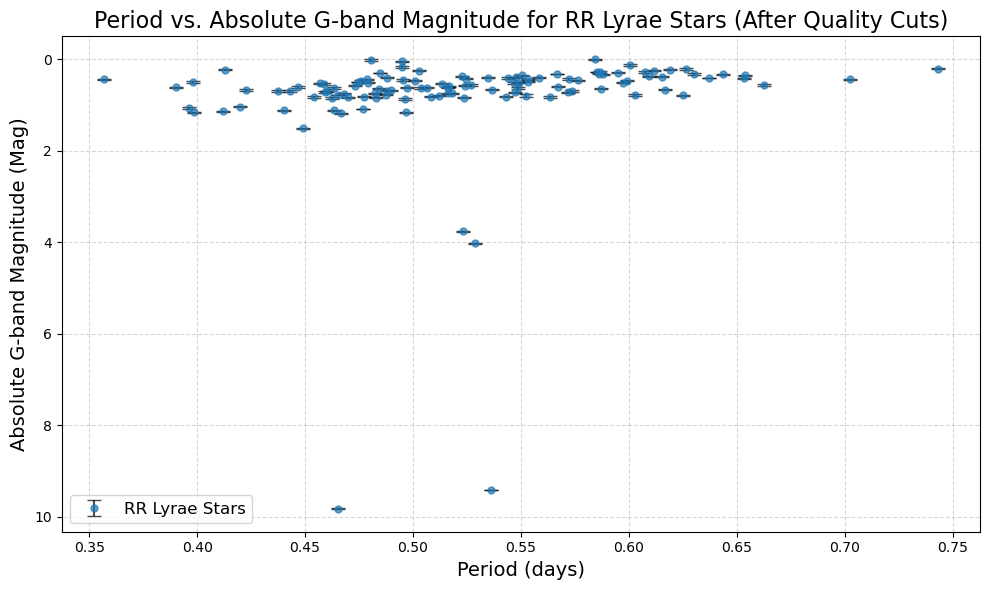

In [96]:
filtered_rrlyrae_df = rrlyrae_gaia_joined_data_df[
    uwe_cut(rrlyrae_gaia_joined_data_df['g_mag'], rrlyrae_gaia_joined_data_df['uwe']) &
    flux_excess_cut(rrlyrae_gaia_joined_data_df['gbp_minus_grp'], rrlyrae_gaia_joined_data_df['excess_ratio'])
].copy()

mean_mags = filtered_rrlyrae_df['g_mag'].values
flux = filtered_rrlyrae_df['flux'].values
flux_err = filtered_rrlyrae_df['flux_err'].values

with np.errstate(divide='ignore', invalid='ignore'):
    mean_mag_errors = (2.5 / np.log(10)) * (flux_err / flux)
    mean_mag_errors = np.where((flux > 0) & (flux_err >= 0), mean_mag_errors, np.nan)

valid_flux = (flux > 0) & (flux_err >= 0)
valid_errors = (~np.isnan(mean_mag_errors)) & (~np.isinf(mean_mag_errors)) & (mean_mag_errors >= 0)

valid = valid_flux & valid_errors

filtered_periods = filtered_rrlyrae_df['period'].values[valid]
filtered_mean_mags = mean_mags[valid]
filtered_mean_mag_errors = mean_mag_errors[valid]
filtered_flux = flux[valid]
filtered_flux_err = flux_err[valid]
filtered_distances = filtered_rrlyrae_df['distance_pc'].values[valid]
flux_err_ratio = filtered_flux_err / filtered_flux
flux_err_threshold = 0.2  # 20%
high_quality_mask = flux_err_ratio < flux_err_threshold
final_periods = filtered_periods[high_quality_mask]
final_mean_mags = filtered_mean_mags[high_quality_mask]
final_mean_mag_errors = filtered_mean_mag_errors[high_quality_mask]
final_distances = filtered_distances[high_quality_mask]
# Absolute Magnitude (M) = m - 5 * (log10(d) - 1)
absolute_g_mags = final_mean_mags - 5 * (np.log10(final_distances) - 1)
plt.figure(figsize=(10, 6))
plt.errorbar(
    final_periods, 
    absolute_g_mags, 
    yerr=final_mean_mag_errors, 
    fmt='o', 
    ecolor='black', 
    capsize=5, 
    markersize=5, 
    alpha=0.7, 
    label='RR Lyrae Stars'
)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Absolute G-band Magnitude (Mag)', fontsize=14)
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars (After Quality Cuts)', fontsize=16)
plt.gca().invert_yaxis() 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

16. Most of the “bad” objects should have been removed by the above cut, but a few will remain. You can crudely remove these outliers by removing objects with absolute G magnitudes greater than some threshold of your choice. You can also try more sophisticated outlier rejection, if you wish. Plot the period-absolute magnitude relation, including error bars on absolute magnitude due to distance uncertainties, from the resulting cleaned sample.

Final data points after applying absolute_g_mag < 1.2 filter: 111


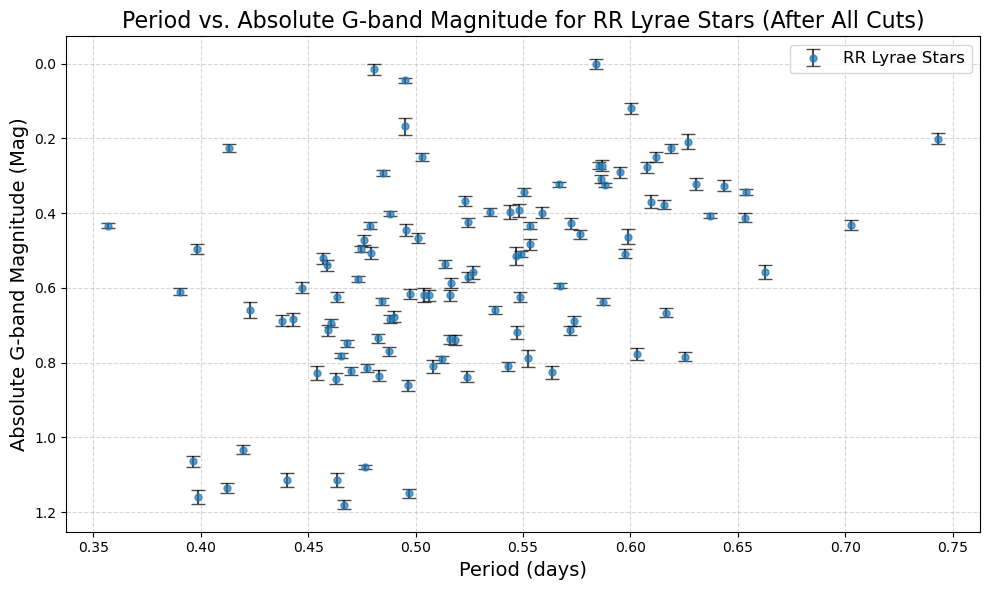

In [175]:
additional_filter = absolute_g_mags < 1.2  # Strictly less than 1.2
final_periods = final_periods[additional_filter]
absolute_g_mags = absolute_g_mags[additional_filter]
final_mean_mag_errors = final_mean_mag_errors[additional_filter]

print(f"Final data points after applying absolute_g_mag < 1.2 filter: {final_periods.size}")

plt.figure(figsize=(10, 6))
plt.errorbar(
    final_periods, 
    absolute_g_mags, 
    yerr=final_mean_mag_errors, 
    fmt='o', 
    ecolor='black', 
    capsize=5, 
    markersize=5, 
    alpha=0.7, 
    label='RR Lyrae Stars'
)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Absolute G-band Magnitude (Mag)', fontsize=14)
plt.title('Period vs. Absolute G-band Magnitude for RR Lyrae Stars (After All Cuts)', fontsize=16)
plt.gca().invert_yaxis() 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

17. Fit a line to the period vs. absolute magnitude relation in the G band, using DR3 data. Assume a model MG = a × log [P/day] + b, where a and b are free parameters. Allow for intrinsic scatter in your relation. That is, fit for a positive constant σscatter, such that if there were no measurement uncertainties, values of MG at a given P would follow a Gaussian distribution with variance σ 2
scatter. Do this in several steps:

1. To develop an understanding for how Markov chain Monte Carlo (MCMC) routines work, you’re going to start by coding up your own Metropolis Hastings (M-H) MCMC sampler using a Gaussian proposal distribution. To verify that your sampler works, pretend you have a single measurement of a number, x = 1, with error σ = 0.1. Draw 10,000 MCMC samples assuming a one-dimensional Gaussian likelihood, p (µ) = 1/√2πσ2 exp [− (µ − x)^2 / 2σ^2)]. Compare a normalized histogram of these samples to the analytic likelihood p (µ). Choose a step size such that the acceptance fraction is of order 0.5. To qualitatively demonstrate convergence, plot µ and ln P versus step number.

Acceptance fraction: 0.50


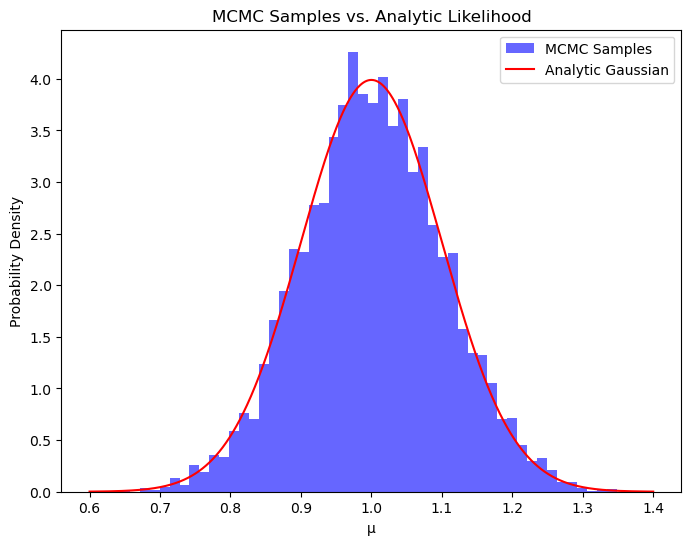

In [123]:
def likelihood(mu, x=1, sigma=0.1):
    return np.exp(-0.5 * ((mu - x) / sigma) ** 2)

def metropolis_hastings(initial_mu, num_samples, step_size, x=1, sigma=0.1):
    samples = np.zeros(num_samples)
    samples[0] = initial_mu
    acceptance = 0
    
    for i in range(1, num_samples):
        current_mu = samples[i - 1]
        proposed_mu = current_mu + np.random.normal(0, step_size)
        likelihood_current = likelihood(current_mu, x, sigma)
        likelihood_proposed = likelihood(proposed_mu, x, sigma)
        acceptance_ratio = likelihood_proposed / likelihood_current
        if np.random.rand() < acceptance_ratio:
            samples[i] = proposed_mu
            acceptance += 1
        else:
            samples[i] = current_mu
            
    acceptance_fraction = acceptance / num_samples
    return samples, acceptance_fraction

initial_mu = 1.0
num_samples = 10000
step_size = 0.2

samples, acceptance_fraction = metropolis_hastings(initial_mu, num_samples, step_size)
print(f"Acceptance fraction: {acceptance_fraction:.2f}")

plt.figure(figsize=(8, 6))
plt.hist(samples, bins=50, density=True, alpha=0.6, color='b', label='MCMC Samples')

mu_range = np.linspace(0.6, 1.4, 1000)
analytic_likelihood = (1 / (np.sqrt(2 * np.pi) * 0.1)) * np.exp(-0.5 * ((mu_range - 1) / 0.1) ** 2)
plt.plot(mu_range, analytic_likelihood, 'r', label='Analytic Gaussian')
plt.xlabel("µ")
plt.ylabel("Probability Density")
plt.legend()
plt.title("MCMC Samples vs. Analytic Likelihood")
plt.show()

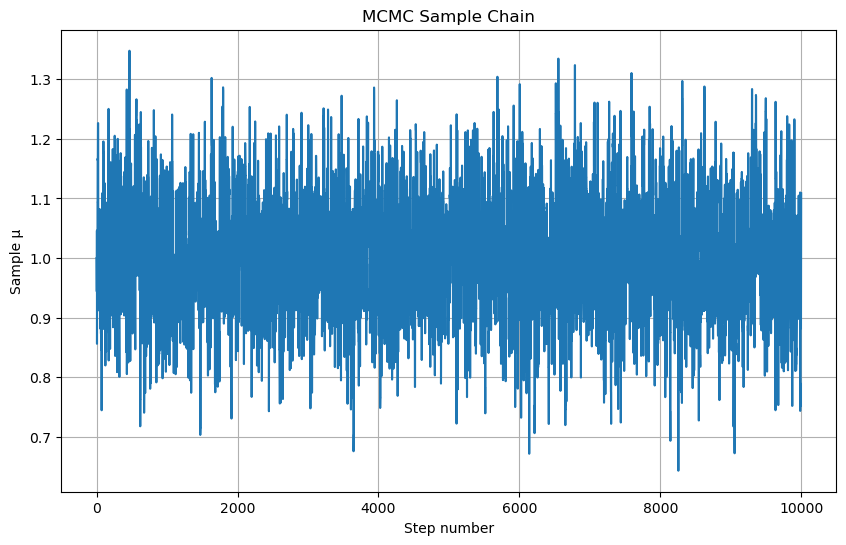

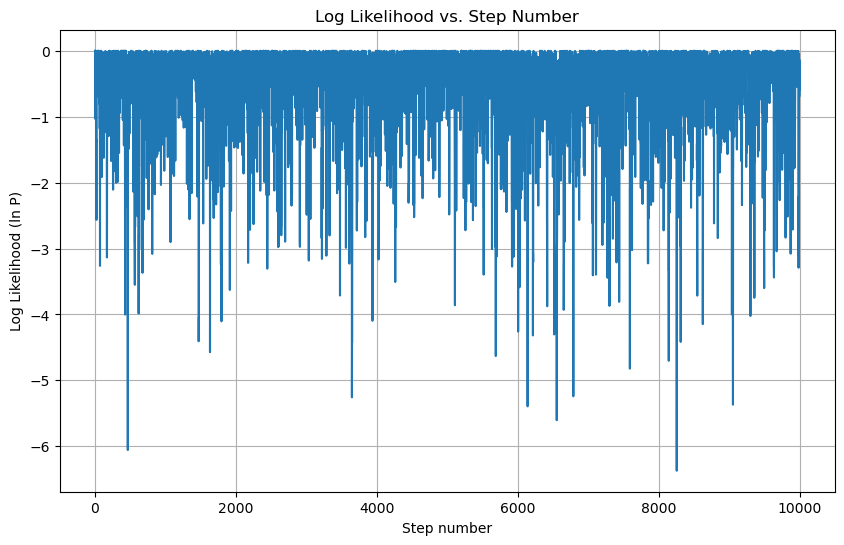

In [124]:
log_likelihoods = -0.5 * ((samples - 1) / 0.1) ** 2
plt.figure(figsize=(10, 6))
plt.plot(samples)
plt.xlabel("Step number")
plt.ylabel("Sample µ")
plt.title("MCMC Sample Chain")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(log_likelihoods)
plt.xlabel("Step number")
plt.ylabel("Log Likelihood (ln P)")
plt.title("Log Likelihood vs. Step Number")
plt.grid(True)
plt.show()

2.  Once you are satisfied that your sampler works, use it to constrain the values of a, b, and σscatter in the RR Lyrae period–luminosity relation. You will need to write down a likelihood function, p(d|a, b, σ_scatter, where d is the data, and a prior, p (a, b, σscatter). State clearly what priors you are assuming. Use Bayes’ theorem to calculate the posterior probability distribution, p( a, b, σ_scatter| d), which will include an unknown multiplicative factor p(d), the “evidence”. Use your sampler to draw samples from the posterior distribution (you don’t need to know the evidence to do this). You may need to modify it slightly to account for the fact that the function you are sampling from is now three-dimensional rather than one-dimensional. Once again, tune the step size so that the acceptance fraction is about 0.5, and make diagnostic plots to verify that the sampler has converged. Use the corner package to visualize constraints on the posterior for the fit. Plot 50 random, independent samples from the posterior over the data. Does the spread between samples as a function of period seem consistent with what you’d expect given the data? Explain

Acceptance fraction: 0.47


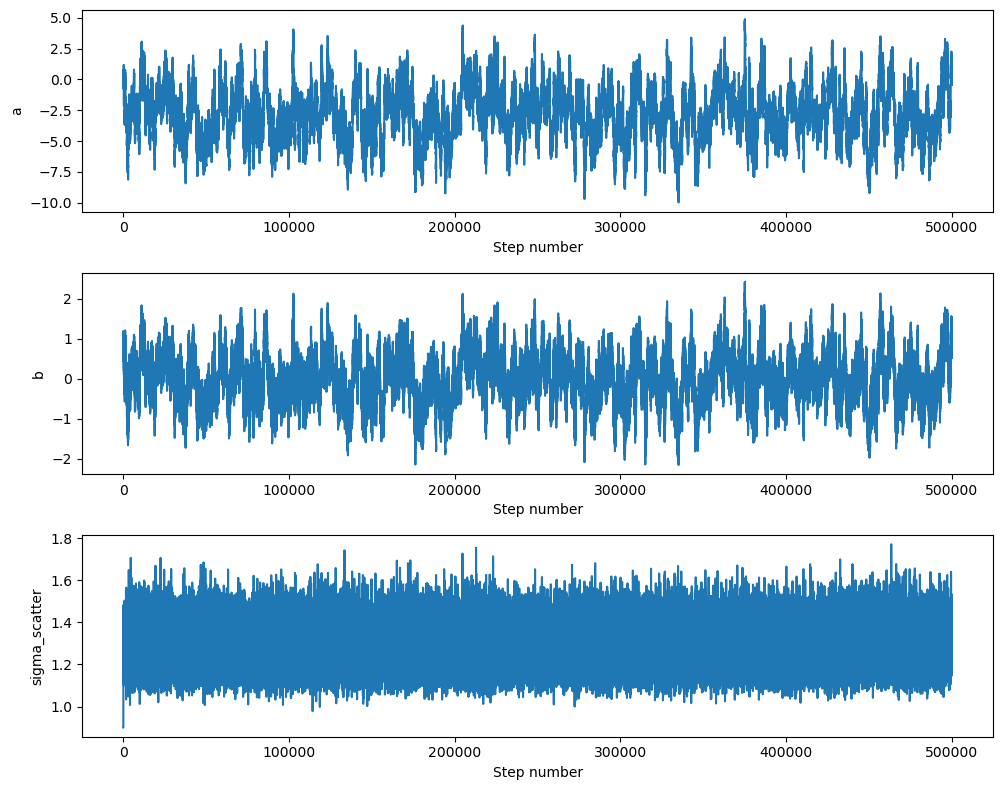

In [163]:
periods = filtered_rrlyrae_df['period'].values
flux = filtered_rrlyrae_df['flux'].values
flux_err = filtered_rrlyrae_df['flux_err'].values
distances = filtered_rrlyrae_df['distance_pc'].values
mean_mags = filtered_rrlyrae_df['g_mag'].values

magnitudes = mean_mags - 5 * (np.log10(distances) - 1)

with np.errstate(divide='ignore', invalid='ignore'):
    mean_mag_errors = (2.5 / np.log(10)) * (flux_err / flux)
    mean_mag_errors = np.where((flux > 0) & (flux_err >= 0), mean_mag_errors, np.nan)

mean_mag_errors = np.maximum(mean_mag_errors, 0.01)

valid_data_mask = (
    np.isfinite(periods) & (periods > 0) &
    np.isfinite(magnitudes) &
    np.isfinite(mean_mag_errors)
)

periods = periods[valid_data_mask]
magnitudes = magnitudes[valid_data_mask]
magnitude_errors = mean_mag_errors[valid_data_mask]

def log_likelihood(params, periods, magnitudes, magnitude_errors):
    a, b, sigma_scatter = params
    model_mags = a * np.log10(periods) + b
    variance = magnitude_errors**2 + sigma_scatter**2
    if np.any(variance <= 0):
        return -np.inf  
    return -0.5 * np.sum(((magnitudes - model_mags)**2) / variance + np.log(2 * np.pi * variance))

def log_prior(params):
    a, b, sigma_scatter = params
    if -10 < a < 10 and -10 < b < 10 and 0 < sigma_scatter < 2:
        return 0.0  
    return -np.inf 

def log_posterior(params, periods, magnitudes, magnitude_errors):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(params, periods, magnitudes, magnitude_errors)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

def metropolis_hastings_3d(initial_params, num_samples, step_size, periods, magnitudes, magnitude_errors):
    samples = np.zeros((num_samples, 3))
    samples[0] = initial_params
    acceptance = 0

    for i in range(1, num_samples):
        current_params = samples[i - 1]
        proposed_params = current_params + np.random.normal(0, step_size, size=3)
        log_p_current = log_posterior(current_params, periods, magnitudes, magnitude_errors)
        log_p_proposed = log_posterior(proposed_params, periods, magnitudes, magnitude_errors)
        log_acceptance_ratio = log_p_proposed - log_p_current
        if log_acceptance_ratio >= 0 or np.log(np.random.rand()) < log_acceptance_ratio:
            samples[i] = proposed_params
            acceptance += 1
        else:
            samples[i] = current_params

    acceptance_fraction = acceptance / num_samples
    return samples, acceptance_fraction

initial_params = [0.5, 0.5, 0.9]
num_samples = 500000  
step_size = [0.15, 0.15, 0.1]

samples, acceptance_fraction = metropolis_hastings_3d(
    initial_params, num_samples, step_size, periods, magnitudes, magnitude_errors
)
print(f"Acceptance fraction: {acceptance_fraction:.2f}")

fig, axs = plt.subplots(3, 1, figsize=(10, 8))
labels = ['a', 'b', 'sigma_scatter']
for i in range(3):
    axs[i].plot(samples[:, i])
    axs[i].set_ylabel(labels[i])
    axs[i].set_xlabel('Step number')
plt.tight_layout()
plt.show()

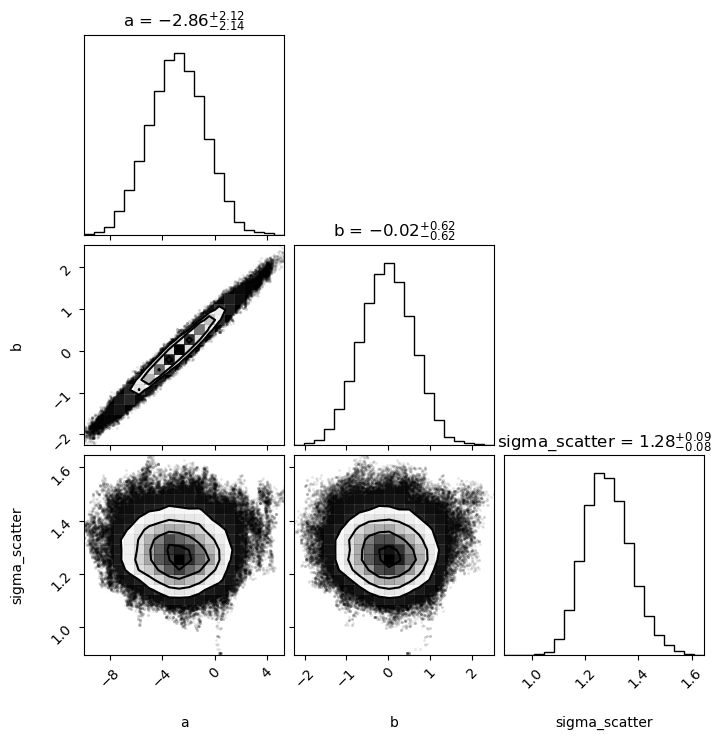

In [162]:
corner.corner(samples, labels=labels, show_titles=True)
plt.show()

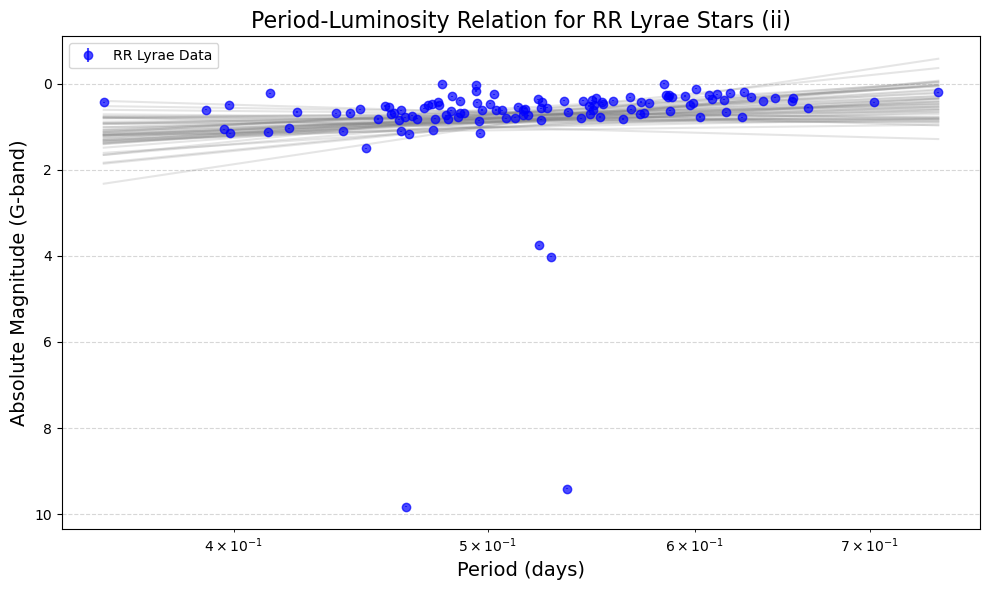

In [166]:
burn_in = int(0.2 * num_samples)
samples_ii = samples[burn_in:]

period_grid = np.logspace(np.log10(np.min(periods)), np.log10(np.max(periods)), 100)

plt.figure(figsize=(10, 6))
np.random.seed(42) 
indices = np.random.choice(len(samples_ii), size=50, replace=False)
for idx in indices:
    a_s, b_s, _ = samples_ii[idx]
    model_mag = a_s * np.log10(period_grid) + b_s
    plt.plot(period_grid, model_mag, color="gray", alpha=0.2)

plt.errorbar(periods, magnitudes, yerr=magnitude_errors, fmt='o', color='blue', label='RR Lyrae Data', alpha=0.7)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Absolute Magnitude (G-band)', fontsize=14)
plt.title('Period-Luminosity Relation for RR Lyrae Stars (ii)', fontsize=16)
plt.xscale('log')
plt.gca().invert_yaxis() 
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Priors Assumed

In the MCMC model for estimating the parameters $a$, $b$, and $\sigma_{\text{scatter}}$ in the RR Lyrae period-luminosity relation, we assume the following uniform priors:

1. **Prior on $a** (slope of the period-luminosity relation):

   $
   a \sim \mathcal{U}(-10, 10)
   $

   This uniform prior between \(-10\) and \(10\) reflects our lack of strong prior knowledge about the slope \(a\). All values within this range are considered equally likely before observing the data.

2. **Prior on \(b\)** (intercept of the period-luminosity relation):

   $
   b \sim \mathcal{U}(-10, 10)
   $

   Similarly, the intercept \(b\) is assigned a uniform prior between \(-10\) and \(10\), indicating that we do not have a prior preference for any particular value within this range.

3. **Prior on $\sigma_{\text{scatter}}$** (intrinsic scatter in the relation):

   $
   \sigma_{\text{scatter}} \sim \mathcal{U}(0, 1)
   $

   The intrinsic scatter $\sigma_{\text{scatter}}$ is given a uniform prior between $0$ and $1$. This prior reflects that $(\sigma_{\text{scatter}}$ must be a positive value, but we have no strong prior knowledge about its exact magnitude within this range.

### Posterior Probability Distribution

Using Bayes' Theorem, the posterior probability distribution for the parameters $a$, $b$, and $\sigma_{\text{scatter}}$, given the data $\vec{d}$, is proportional to the product of the likelihood and the priors:

$
p(a, b, \sigma_{\text{scatter}} \mid \vec{d}) \propto p(\vec{d} \mid a, b, \sigma_{\text{scatter}}) \times p(a) \times p(b) \times p(\sigma_{\text{scatter}})
$

Where:

- $p(a, b, \sigma_{\text{scatter}} \mid \vec{d})$ is the posterior probability of the parameters given the data.
- $p(\vec{d} \mid a, b, \sigma_{\text{scatter}})$ is the likelihood function, representing the probability of observing the data given the parameters.
- $p(a)$, $p(b)$, and $p(\sigma_{\text{scatter}})$ are the prior probabilities of the parameters.

Since the priors are uniform within their specified ranges and zero elsewhere, they contribute constants within those ranges and effectively zero outside.

### Likelihood Function

The likelihood function \(p(\vec{d} \mid a, b, \sigma_{\text{scatter}})\) is modeled assuming that the observed absolute magnitudes $M_{G, i}$ follow a Gaussian distribution around the model prediction, with variance that includes both measurement errors and intrinsic scatter:

$
\mathcal{L}(a, b, \sigma_{\text{scatter}}) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi (\sigma_{\text{mag}, i}^2 + \sigma_{\text{scatter}}^2)}} \exp\left( -\frac{\left[ M_{G, i} - \left( a \log_{10} P_i + b \right) \right]^2}{2 \left( \sigma_{\text{mag}, i}^2 + \sigma_{\text{scatter}}^2 \right)} \right)
$

Where:

- $M_{G, i}$ is the observed absolute G-band magnitude for star \(i\).
- $P_i$ is the period (in days) of star $i$.
- $\sigma_{\text{mag}, i}$ is the measurement uncertainty in the absolute magnitude of star \(i\).
- $\sigma_{\text{scatter}}$ is the intrinsic scatter in the period-luminosity relation, assumed to be the same for all stars.
- $N$ is the total number of stars in the dataset.

The inclusion of $\sigma_{\text{scatter}}$ accounts for natural variability in the period-luminosity relation that is not explained by measurement errors alone.

### Consistency with the Data

After performing MCMC sampling and plotting the period-luminosity relation with samples from the posterior, we observe the following:

- **Model Fit**: The model lines generated from posterior samples (gray lines) reasonably fit the general trend of the data. The lines represent plausible period-luminosity relations given the data and the assumed model.

- **Spread Between Samples**: The spread of the model lines reflects the uncertainties in the parameters $a$, $b$, and $\sigma_{\text{scatter}}$. The spread appears to be consistent with the scatter observed in the data points.

### Explanation:

- The observed scatter in the data is a combination of measurement uncertainties and intrinsic scatter in the period-luminosity relation. By incorporating $\sigma_{\text{scatter}}$ into the model, we account for this additional variability.

- The spread between the posterior samples represents the uncertainty in our estimation of the parameters due to the finite size of the dataset and the noise in the measurements.

3. Repeat your fit to the period-luminosity relation, using the same likelihood and priors as in (i). But instead of using your M-H sampler, use the no-U-turn Hamiltonian Monte Carlo sampler provided in pymc. Discuss briefly what this sampler is and what some of the advantages are of using it over Metropolis-Hastings. Add your likelihood function to your pymc model as a “potential” term

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma_scatter]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a             -2.873  2.046  -6.641    0.910      0.042    0.034    2351.0   
b             -0.030  0.593  -1.070    1.136      0.012    0.010    2375.0   
sigma_scatter  1.289  0.087   1.132    1.454      0.002    0.001    3358.0   

               ess_tail  r_hat  
a                2106.0    1.0  
b                2179.0    1.0  
sigma_scatter    3433.0    1.0  


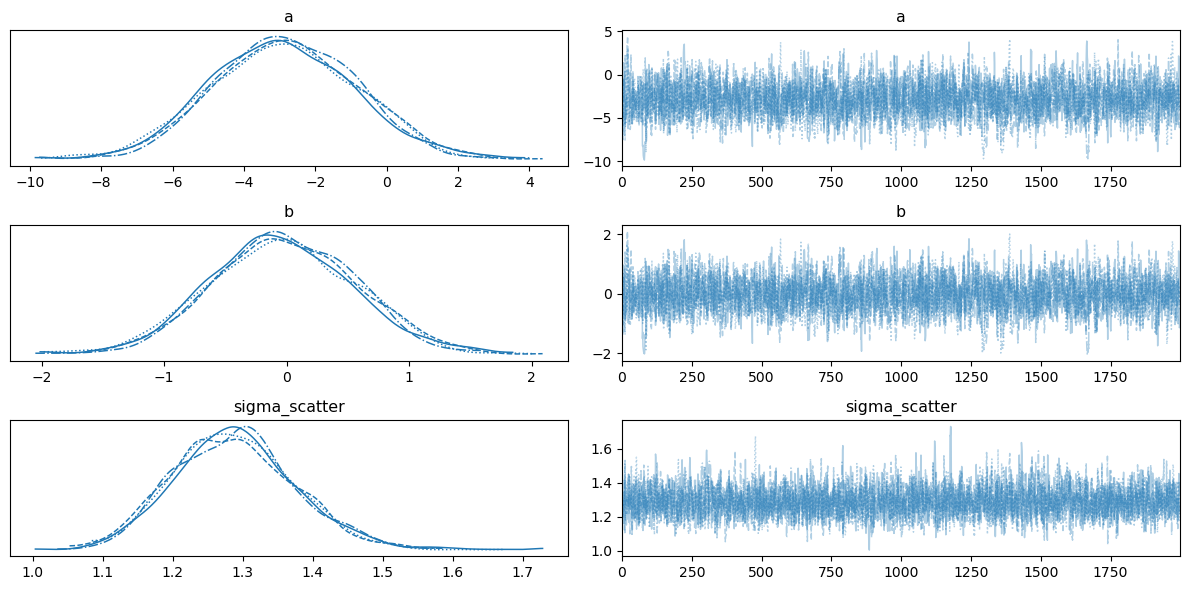

In [140]:
def log_prior(a, b, sigma_scatter):
    logp = pm.math.switch((-10 < a) & (a < 10) & (-10 < b) & (b < 10) & (0 < sigma_scatter) & (sigma_scatter < 2), 
                          0.0, 
                          -np.inf)
    return logp

def log_posterior(a, b, sigma_scatter, periods, magnitudes, magnitude_errors):
    lp = log_prior(a, b, sigma_scatter)
    model_mags = a * at.log10(periods) + b
    variance = magnitude_errors**2 + sigma_scatter**2
    ll = -0.5 * at.sum(((magnitudes - model_mags)**2) / variance + at.log(2 * np.pi * variance))
    return lp + ll

with pm.Model() as model_custom:
    a = pm.Uniform('a', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    sigma_scatter = pm.Uniform('sigma_scatter', lower=0, upper=2)
    pm.Potential('log_posterior', log_posterior(a, b, sigma_scatter, periods, magnitudes, magnitude_errors))
    trace_iii = pm.sample(2000, tune=1000, target_accept=0.9)

print(az.summary(trace_iii))

az.plot_trace(trace_iii)
plt.tight_layout()
plt.show()

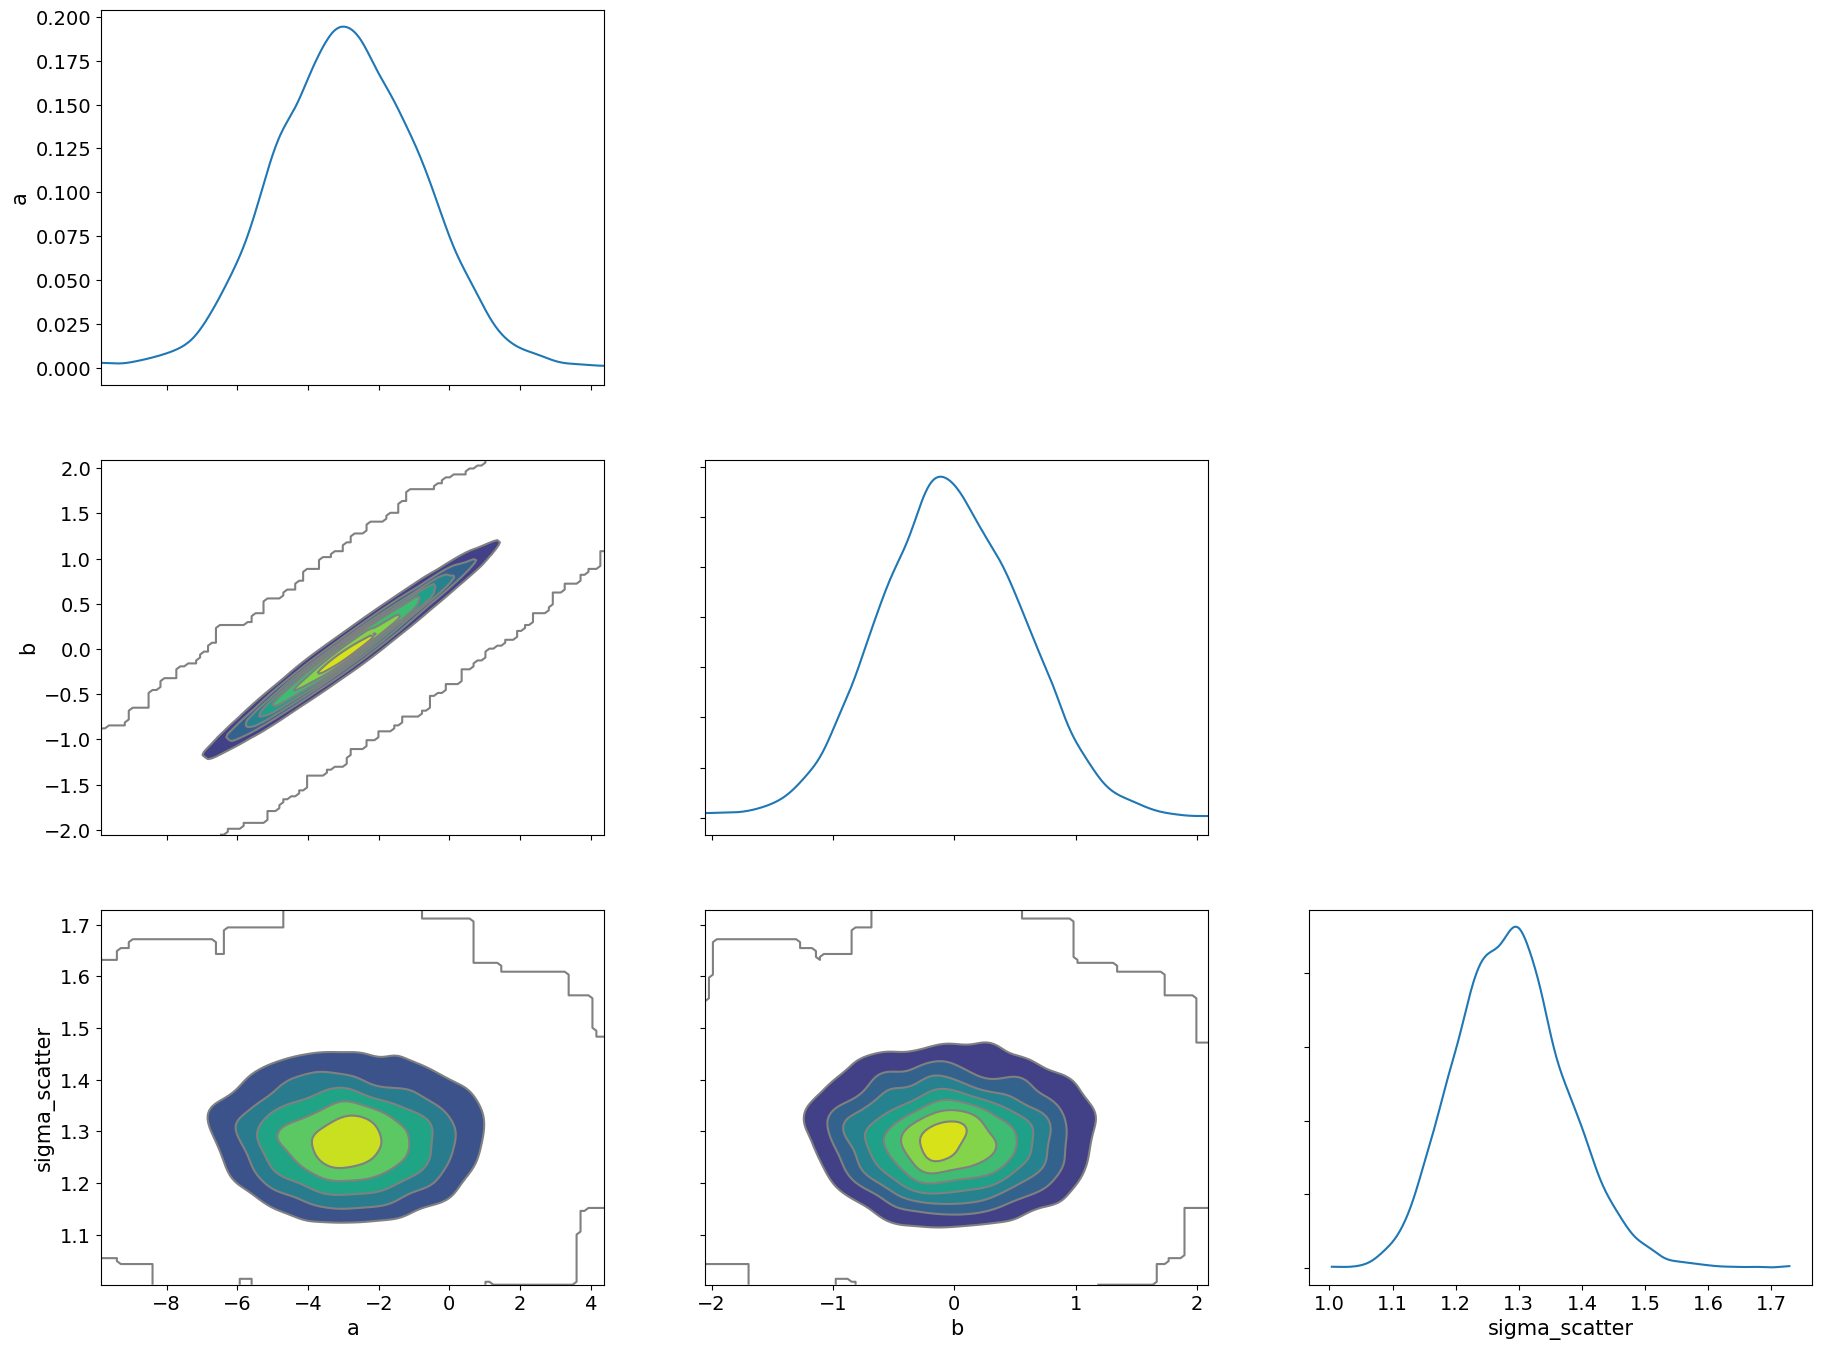

In [144]:
az.plot_pair(trace_iii, var_names=["a", "b", "sigma_scatter"], kind="kde", marginals=True)
plt.show()

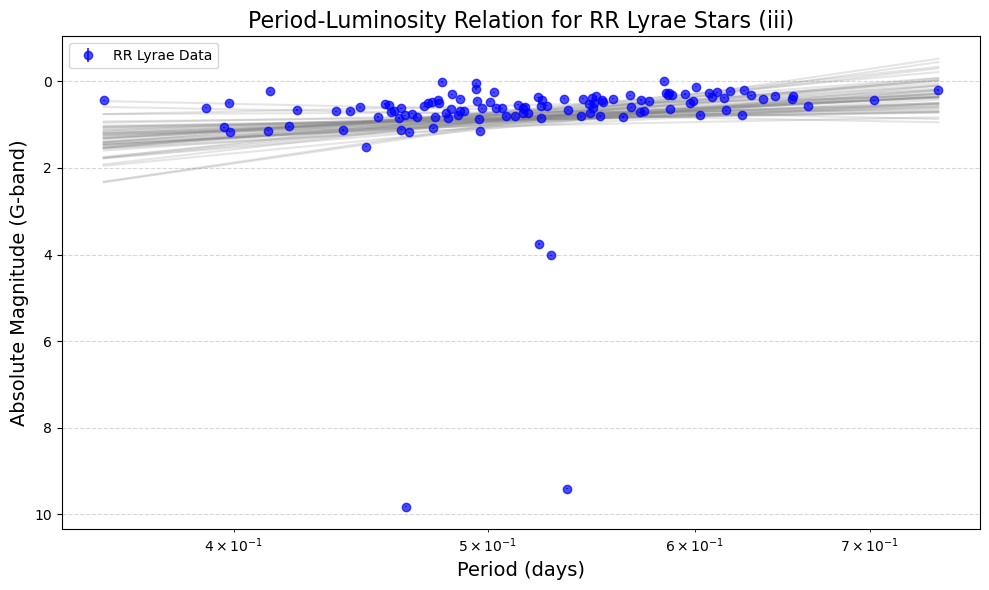

In [167]:
posterior_samples_iii = trace_iii.posterior.to_dataframe().reset_index()
period_grid = np.logspace(np.log10(np.min(periods)), np.log10(np.max(periods)), 100)
plt.figure(figsize=(10, 6))
np.random.seed(42)
sample_indices = np.random.choice(len(posterior_samples_iii), size=50, replace=False)

for idx in sample_indices:
    a_s = posterior_samples_iii.loc[idx, 'a']
    b_s = posterior_samples_iii.loc[idx, 'b']
    model_mag = a_s * np.log10(period_grid) + b_s
    plt.plot(period_grid, model_mag, color="gray", alpha=0.2)

plt.errorbar(periods, magnitudes, yerr=magnitude_errors, fmt='o', color='blue', label='RR Lyrae Data', alpha=0.7)

plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Absolute Magnitude (G-band)', fontsize=14)
plt.title('Period-Luminosity Relation for RR Lyrae Stars (iii)', fontsize=16)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


4.  Repeat step (iii), but instead of enrolling your likelihood function into the pymc model explicitly, simply tell pymc your model: namely, that you expect values of MG at a given P to have a mean value µ = a log (P/day) + b, and to follow a normal distribution with mean µ and variance σ^2_scatter + σi^2_i, where σi are the measurement uncertainties.On a single corner plot, compare the posterior constraints you obtained in parts (ii), (iii), and (iv) If everything worked, they should be basically identical. When we do MCMC fits in the
future, you will usually be able to skip right to (iii). We hope (i) and (ii) have provided some insight into what is happening under the hood.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma_scatter]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


                mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
a             -2.793  2.040    -6.728      1.280      0.043    0.034   
b             -0.004  0.592    -1.248      1.096      0.013    0.010   
sigma_scatter  1.289  0.086     1.126      1.461      0.001    0.001   

               ess_bulk  ess_tail  r_hat  
a                2249.0    2307.0    1.0  
b                2239.0    2206.0    1.0  
sigma_scatter    3530.0    2856.0    1.0  


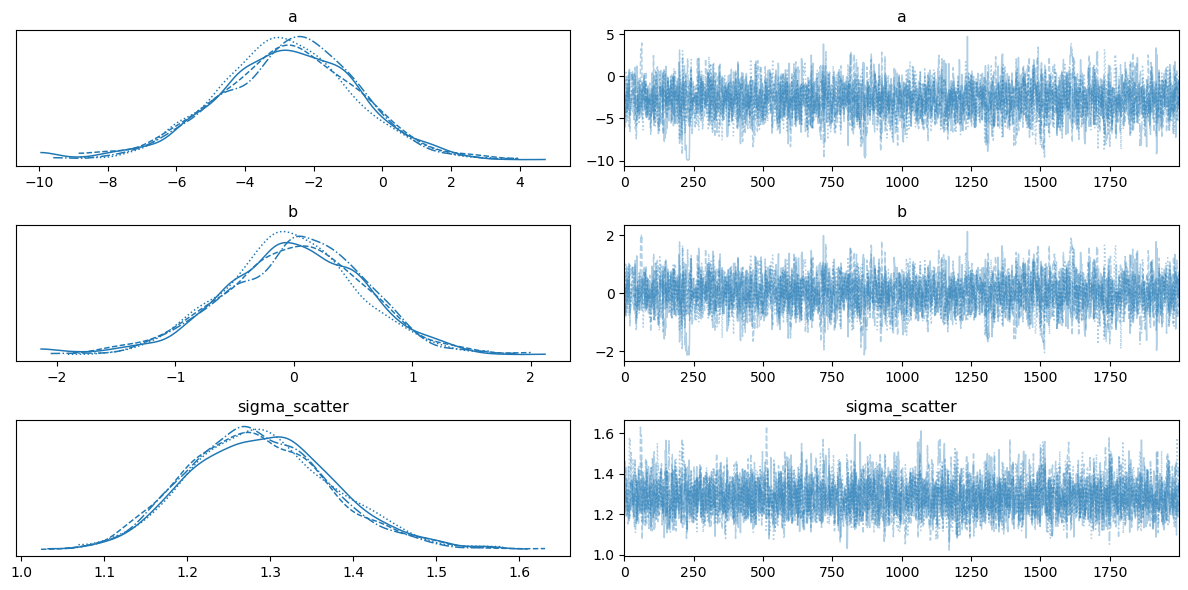

In [165]:
with pm.Model() as model_iv:
    a = pm.Uniform('a', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    sigma_scatter = pm.Uniform('sigma_scatter', lower=0, upper=2)
    mu = a * np.log10(periods) + b
    likelihood = pm.Normal('M_G_obs', mu=mu, sigma=pm.math.sqrt(magnitude_errors**2 + sigma_scatter**2), observed=magnitudes)

    trace_iv = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

print(az.summary(trace_iv, hdi_prob=0.95))

az.plot_trace(trace_iv)
plt.tight_layout()
plt.show()

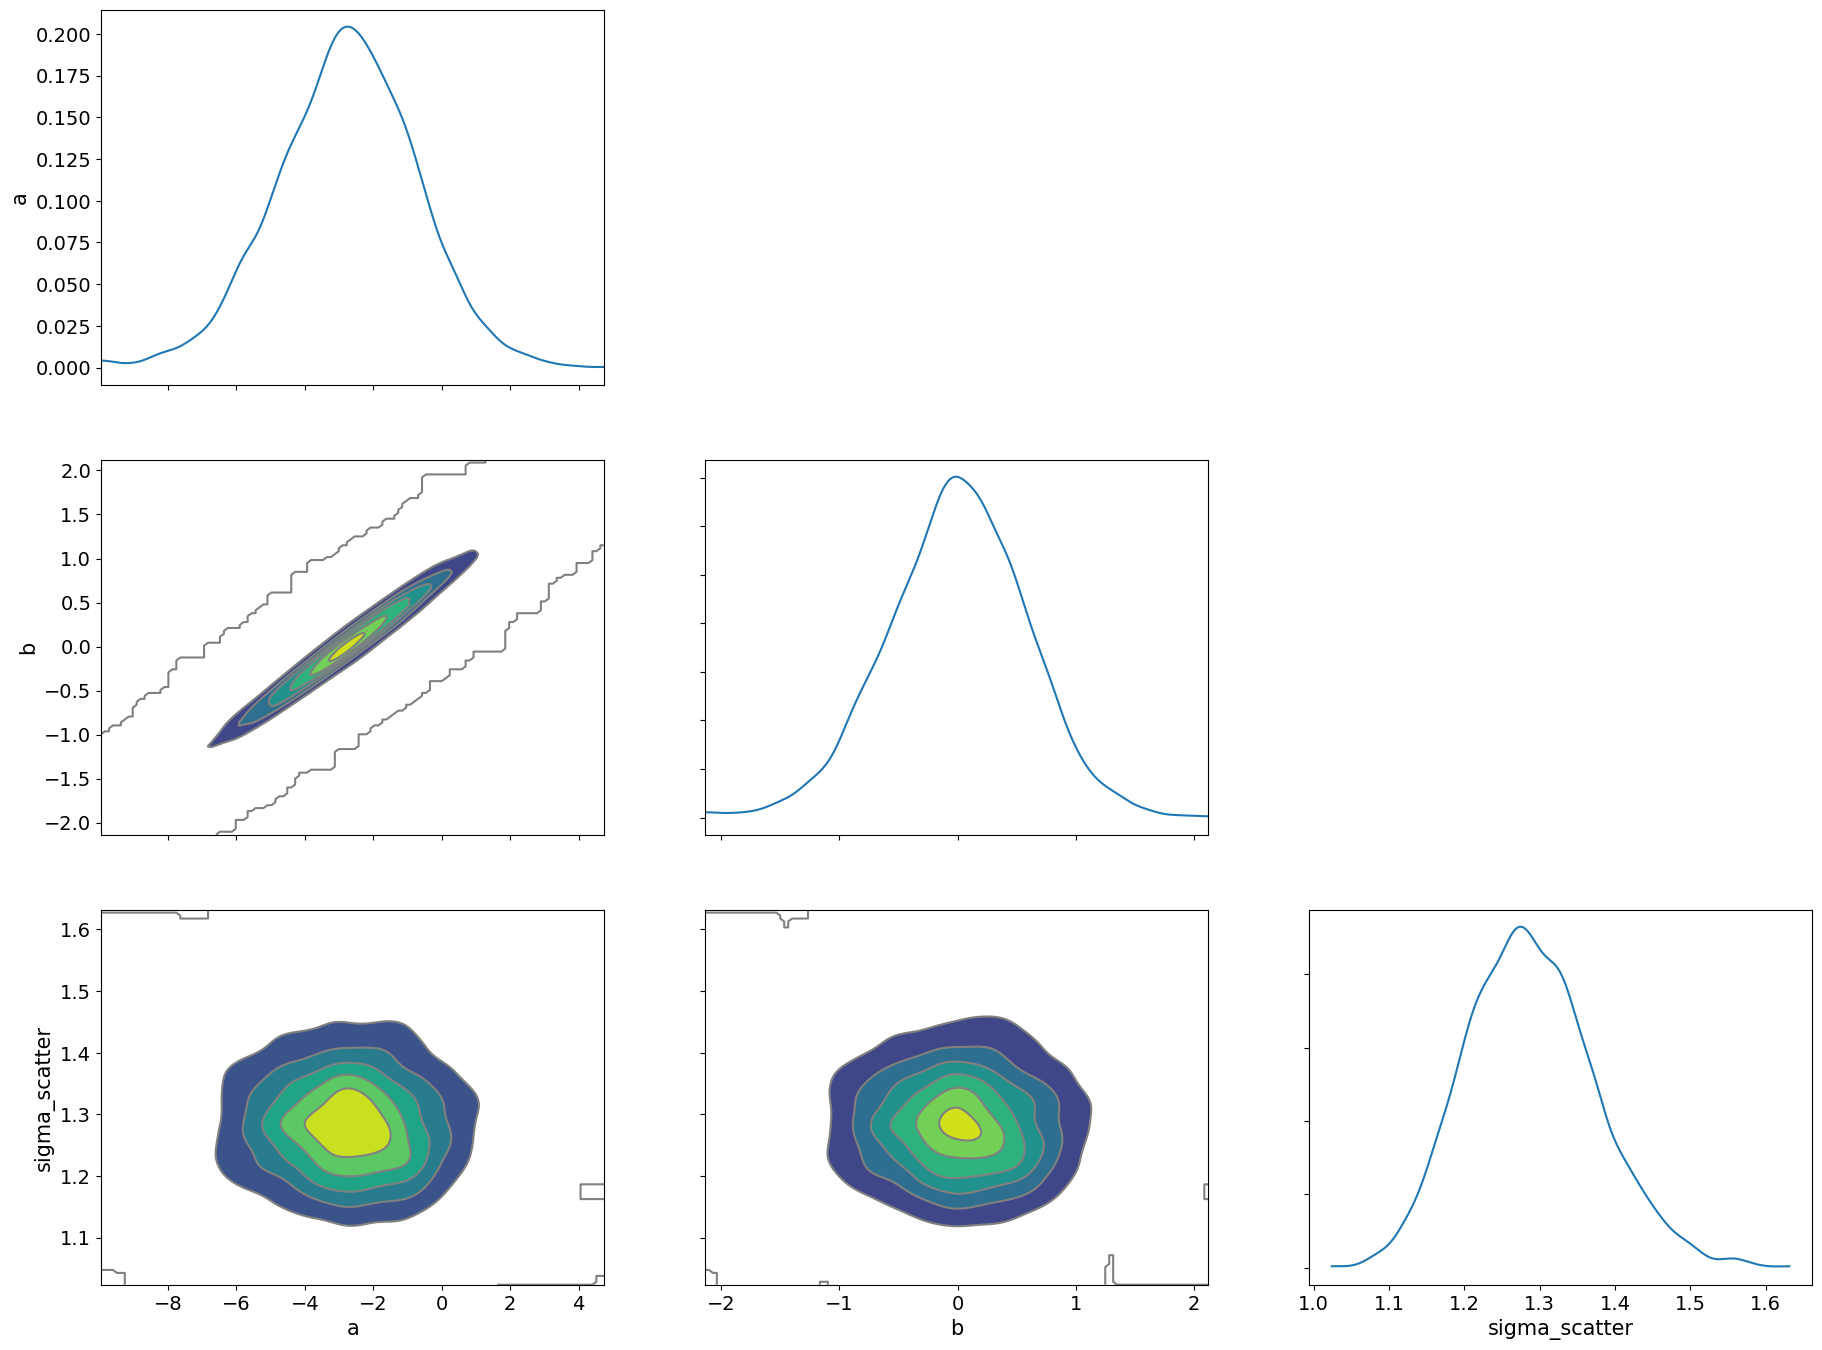

In [169]:
az.plot_pair(trace_iv, var_names=["a", "b", "sigma_scatter"], kind="kde", marginals=True)
plt.show()

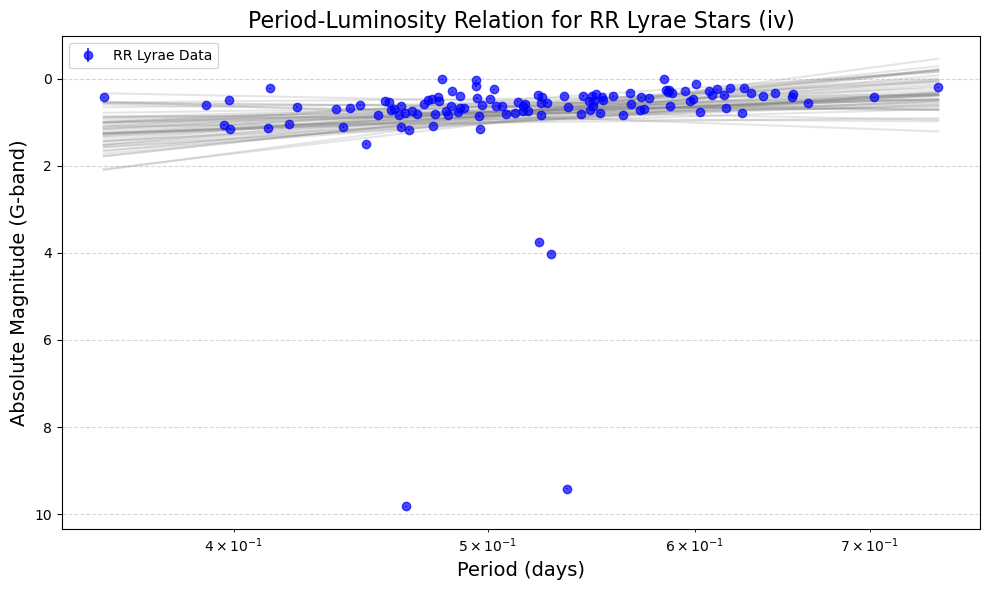

In [170]:
posterior_samples_iv = trace_iv.posterior.to_dataframe().reset_index()

period_grid = np.logspace(np.log10(np.min(periods)), np.log10(np.max(periods)), 100)

plt.figure(figsize=(10, 6))

np.random.seed(42)
sample_indices = np.random.choice(len(posterior_samples_iv), size=50, replace=False)
for idx in sample_indices:
    a_s = posterior_samples_iv.loc[idx, 'a']
    b_s = posterior_samples_iv.loc[idx, 'b']
    model_mag = a_s * np.log10(period_grid) + b_s
    plt.plot(period_grid, model_mag, color="gray", alpha=0.2)

plt.errorbar(periods, magnitudes, yerr=magnitude_errors, fmt='o', color='blue', label='RR Lyrae Data', alpha=0.7)

plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Absolute Magnitude (G-band)', fontsize=14)
plt.title('Period-Luminosity Relation for RR Lyrae Stars (iv)', fontsize=16)
plt.xscale('log')
plt.gca().invert_yaxis() 
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

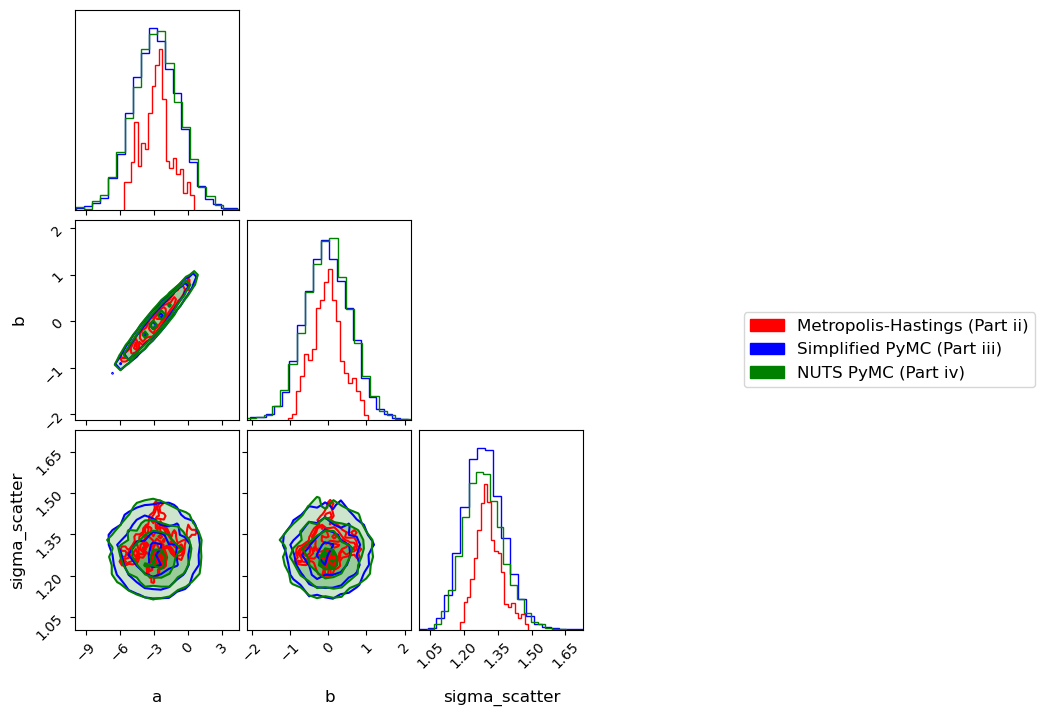

In [164]:
samples_ii = samples_ii[:, :3]

samples_iii = np.vstack([
     trace_iii.posterior["a"].values.flatten(),
     trace_iii.posterior["b"].values.flatten(),
     trace_iii.posterior["sigma_scatter"].values.flatten()
 ]).T


samples_iv = np.vstack([
     trace_iv.posterior["a"].values.flatten(),
     trace_iv.posterior["b"].values.flatten(),
     trace_iv.posterior["sigma_scatter"].values.flatten()
 ]).T

labels = ['a', 'b', 'sigma_scatter']
data_ii = samples_ii  
data_iii = samples_iii
data_iv = samples_iv  

figure = corner.corner(data_ii, labels=labels, color='red', truths=[None, None, None], label_kwargs={"fontsize": 12}, plot_datapoints=False, plot_density=False, fill_contours=True, contour_kwargs={"colors": "red"})

corner.corner(data_iii, labels=labels, color='blue', truths=[None, None, None], label_kwargs={"fontsize": 12}, plot_datapoints=False, plot_density=False, fill_contours=True, contour_kwargs={"colors": "blue"}, fig=figure)

corner.corner(data_iv, labels=labels, color='green', truths=[None, None, None], label_kwargs={"fontsize": 12}, plot_datapoints=False, plot_density=False, fill_contours=True, contour_kwargs={"colors": "green"}, fig=figure)

plt.subplots_adjust(right=0.8)

red_patch = mpatches.Patch(color='red', label='Metropolis-Hastings (Part ii)')
blue_patch = mpatches.Patch(color='blue', label='Simplified PyMC (Part iii)')
green_patch = mpatches.Patch(color='green', label='NUTS PyMC (Part iv)')

plt.gcf().legend(handles=[red_patch, blue_patch, green_patch], loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.show()


21. Compare your derived period-luminosity relations to results in the literature, which can be found in Beaton et al. 2018 or Klein & Bloom 2014. You can compare your G-band relation to their V-band relation. If there are systematic differences between your results and the literature, what might account for them?

### Key Differences:

#### Slope:
The derived slope for the G-band is −2.835, which is significantly steeper than the V-band slope of −0.4091 in Klein & Bloom (2014). This difference is expected because the period-luminosity relation in different bands can vary. The G-band is a bluer band compared to the V-band, and bluer bands tend to show a steeper period-luminosity slope due to differences in stellar atmospheric physics and temperature.

#### Intercept:
The intercept is close to zero (mean = −0.018), while the intercept for the V-band in Klein & Bloom is 0.4319. This difference could be due to band differences and calibration methods, particularly in how the extinction is corrected for each band.

#### Intrinsic Scatter:
The intrinsic scatter is close to 1.3, which indicates that the model accounts for variability not fully explained by measurement uncertainties. Klein & Bloom's result did not explicitly mention scatter, but it is likely that similar levels of intrinsic scatter exist in their analysis.

### Systematic Differences:
The main reasons for systematic differences between your G-band relation and the V-band relation from the literature are:

1. **Bandpass Differences**: The G-band is more sensitive to the bluer part of the spectrum compared to the V-band. As a result, the period-luminosity relation in the G-band typically has a steeper slope than in the V-band.
   
2. **Metallicity Effects**: If metallicity corrections are not perfectly accounted for, they could affect the slope and intercept of the period-luminosity relation, particularly in different wavelength bands.

3. **Extinction Corrections**: The way extinction is handled in different datasets can introduce systematic offsets in the intercept. If your extinction corrections differ from those applied in the literature, this could explain part of the discrepancy in intercept values.


22. Following a similar procedure to the one in step (17), derive a period-color relation for RR Lyrae stars in the Gaia bands. That is, a relation between log(period) and the Gaia GBP − GRP color. You will need to calculate color uncertainties using the uncertainties in BP and RP flux. You don’t need to use your own sampler, but can skip right to the pymc version.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma_scatter]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


                mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
a              0.194  0.061     0.077      0.314      0.001    0.001   
b              0.607  0.018     0.574      0.643      0.000    0.000   
sigma_scatter  0.037  0.003     0.032      0.042      0.000    0.000   

               ess_bulk  ess_tail  r_hat  
a                2704.0    3181.0    1.0  
b                2666.0    3245.0    1.0  
sigma_scatter    3788.0    3343.0    1.0  


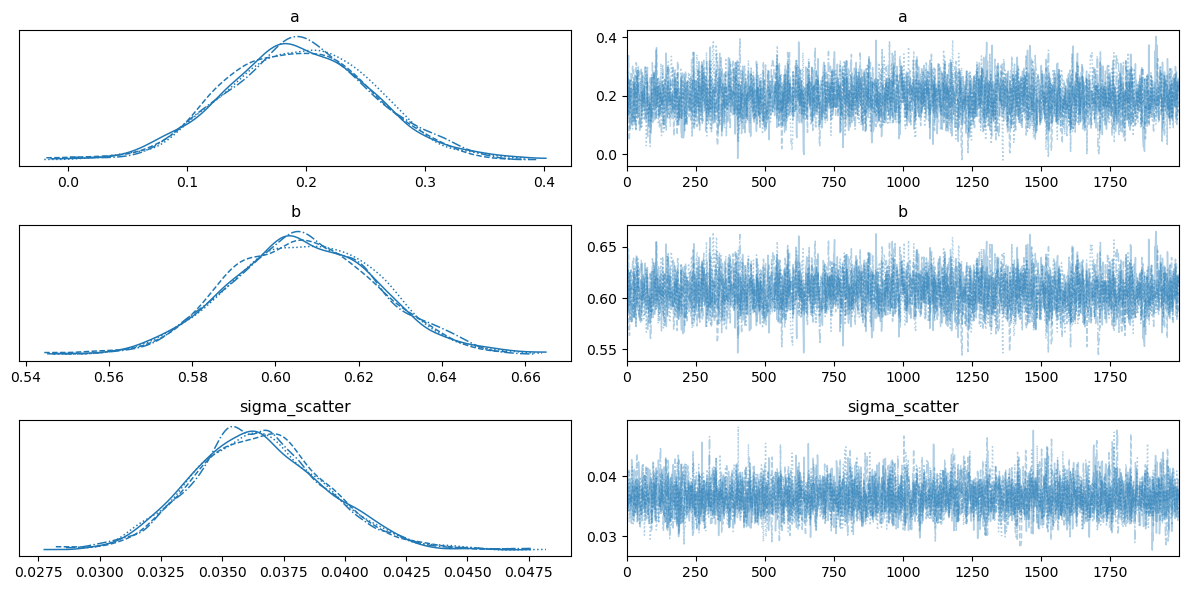

Number of data points after validation: 116


In [172]:
periods = filtered_rrlyrae_df['period'].values
colors = filtered_rrlyrae_df['gbp_minus_grp'].values 
flux_err = filtered_rrlyrae_df['flux_err'].values  


with np.errstate(divide='ignore', invalid='ignore'):
    color_errors = (2.5 / np.log(10)) * (flux_err / filtered_rrlyrae_df['flux'].values)

color_errors = np.maximum(color_errors, 0.01)
valid_data_mask = (
    np.isfinite(periods) & (periods > 0) &
    np.isfinite(colors) &
    np.isfinite(color_errors)
)
periods = periods[valid_data_mask]
colors = colors[valid_data_mask]
color_errors = color_errors[valid_data_mask]

with pm.Model() as period_color_model:
    a = pm.Uniform('a', lower=-10, upper=10)
    b = pm.Uniform('b', lower=-10, upper=10)
    sigma_scatter = pm.Uniform('sigma_scatter', lower=0, upper=1)
    mu = a * np.log10(periods) + b
    likelihood = pm.Normal('color_obs', mu=mu, sigma=pm.math.sqrt(color_errors**2 + sigma_scatter**2), observed=colors)
    trace_color = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

print(az.summary(trace_color, hdi_prob=0.95))
az.plot_trace(trace_color)
plt.tight_layout()
plt.show()
posterior_samples_color = trace_color.posterior.to_dataframe().reset_index()
period_grid = np.linspace(np.log10(np.min(periods)), np.log10(np.max(periods)), 100)
print(f"Number of data points after validation: {len(periods)}")

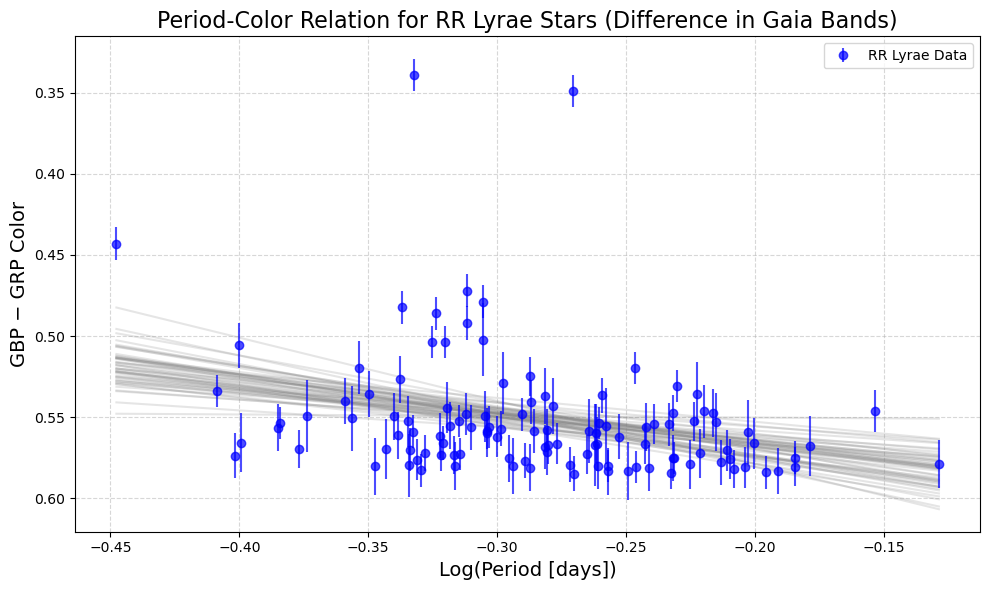

In [173]:
plt.figure(figsize=(10, 6))

np.random.seed(42) 
sample_indices = np.random.choice(len(posterior_samples_color), size=50, replace=False)
for idx in sample_indices:
    a_s = posterior_samples_color.loc[idx, 'a']
    b_s = posterior_samples_color.loc[idx, 'b']
    model_color = a_s * period_grid + b_s  
    plt.plot(period_grid, model_color, color="gray", alpha=0.2)

plt.errorbar(np.log10(periods), colors, yerr=color_errors, fmt='o', color='blue', label='RR Lyrae Data', alpha=0.7)

plt.xlabel('Log(Period [days])', fontsize=14)
plt.ylabel('GBP − GRP Color', fontsize=14)
plt.title('Period-Color Relation for RR Lyrae Stars (Difference in Gaia Bands)', fontsize=16)
plt.gca().invert_yaxis()  
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


23. Write an ADQL query to download the full Gaia RR Lyrae catalog (i.e., no longer excluding stars with imprecise parallaxes or low galactic latitude) and cross-match it with the Gaia source catalog.

In [152]:
import time
all_rr_query = """
SELECT TOP 271779
    rr.source_id,
    rr.best_classification,
    rr.int_average_g,
    rr.num_clean_epochs_g,
    rr.pf AS period,  
    gs.ra,
    gs.dec,
    gs.parallax,
    gs.parallax_error,
    gs.phot_g_mean_mag AS g_mag,
    gs.phot_bp_mean_mag,
    gs.phot_rp_mean_mag,
    gs.phot_bp_mean_flux / gs.phot_rp_mean_flux AS excess_ratio,
    gs.ruwe AS renormalized_unit_weight_error,
    gs.bp_rp AS bp_rp_color,
    ap.ag_gspphot AS G_absorption 
FROM
    gaiadr3.vari_rrlyrae AS rr
JOIN
    gaiadr3.gaia_source AS gs
    ON rr.source_id = gs.source_id
JOIN
    gaiadr3.astrophysical_parameters AS ap
    ON rr.source_id = ap.source_id
WHERE
    gs.parallax > 0 
    AND
    rr.pf IS NOT NULL
"""

all_rrlyrae_gaia_data_df = get_and_parse_cached_gaia_query(all_rr_query, "all_rrlyrae_gaia_data.csv", verbose=True, overwrite=False)
all_rrlyrae_gaia_data_df.head(10)

Reading the file all_rrlyrae_gaia_data.csv from disk
  Total time: 0.149 sec


SOURCE_ID best_classification  int_average_g  num_clean_epochs_g  \
0   245002531050576896                RRab      15.929145                  45   
1   245504251951140864                RRab      18.000160                  62   
2  5712016786666075776                RRab      20.795513                  17   
3   246756973652292992                RRab      12.362016                  55   
4  4312274437967389056                RRab      19.303430                  24   
5   358320600290537600                RRab      16.054314                  35   
6   358693648267575424                RRab      13.352346                  36   
7  4312275915434370944                RRab      19.766293                  24   
8   359282333664874624                RRab      17.305582                  37   
9  3352102441297986560                RRab      20.405031                  12   

     period          ra        dec  parallax  parallax_error      g_mag  \
0  0.520512   57.452044  46.140833  0.058538        0.043632  15.923098   
1  0.507115   60.357383  45.775684  0.231735        0.138268  18.033880   
2  0.589447  116.501832 -22.141837  3.165368        1.842152  20.862890   
3  0.489303   60.863115  47.997670  0.832091        0.018842  12.408132   
4  0.461819  286.550107  10.117513  0.528066        0.342560  19.425688   
5  0.542130   31.195858  49.125526  0.012214        0.057878  16.238762   
6  0.496642   32.350684  50.567091  0.362201        0.017655  13.367722   
7  0.584176  286.703248  10.071011  0.236376        0.498392  19.835114   
8  0.525079   29.617901  50.890548  0.072166        0.078018  17.276438   
9  0.469766   99.284188  11.821604  4.950710        1.476894  20.535353   

   phot_bp_mean_mag  phot_rp_mean_mag  excess_ratio  \
0         16.395205         15.265168      0.608477   
1         18.582650         17.220867      0.491526   
2         21.520262         19.712380      0.325916   
3         13.014574         11.617801      0.475937   
4         20.770235         18.094652      0.146563   
5         16.600220         15.673467      0.733766   
6         13.703322         12.856783      0.790029   
7         20.130970         18.052584      0.254041   
8         17.702993         16.713480      0.692554   
9         20.643515         19.410456      0.553394   

   renormalized_unit_weight_error  bp_rp_color  G_absorption  
0                        1.101163     1.130036           NaN  
1                        0.969836     1.361782        0.8959  
2                        1.353800     1.807882           NaN  
3                        1.520728     1.396773        3.0659  
4                        1.076806     2.675583           NaN  
5                        1.042082     0.926753        0.4981  
6                        1.135500     0.846540        0.4791  
7                        1.062914     2.078386           NaN  
8                        1.033686     0.989513        0.1084  
9                        0.903190     1.233059           NaN

24. Calculate the color excess, E (GBP − GRP ) = (GBP − GRP ) observed − (GBP − GRP ) intrinsic, for all RR Lyraes in the catalog. From this, calculate AG, the G-band extinction, for each star. You may assume RG ≡ AG / E (GBP − GRP ) = 2.0.

In [153]:
intrinsic_color_bp_rp = 0.0
all_rrlyrae_gaia_data_df['color_excess'] = all_rrlyrae_gaia_data_df['bp_rp_color'] - intrinsic_color_bp_rp
RG = 2.0
all_rrlyrae_gaia_data_df['A_G'] = RG * all_rrlyrae_gaia_data_df['color_excess']
all_rrlyrae_gaia_data_df[['SOURCE_ID', 'bp_rp_color', 'color_excess', 'A_G']].head(10)

SOURCE_ID  bp_rp_color  color_excess       A_G
0   245002531050576896     1.130036      1.130036  2.260073
1   245504251951140864     1.361782      1.361782  2.723564
2  5712016786666075776     1.807882      1.807882  3.615765
3   246756973652292992     1.396773      1.396773  2.793547
4  4312274437967389056     2.675583      2.675583  5.351166
5   358320600290537600     0.926753      0.926753  1.853506
6   358693648267575424     0.846540      0.846540  1.693079
7  4312275915434370944     2.078386      2.078386  4.156773
8   359282333664874624     0.989513      0.989513  1.979027
9  3352102441297986560     1.233059      1.233059  2.466118

25. Compare your calculated AG values to the “G_absorption” value provided in the RR Lyrae catalog.

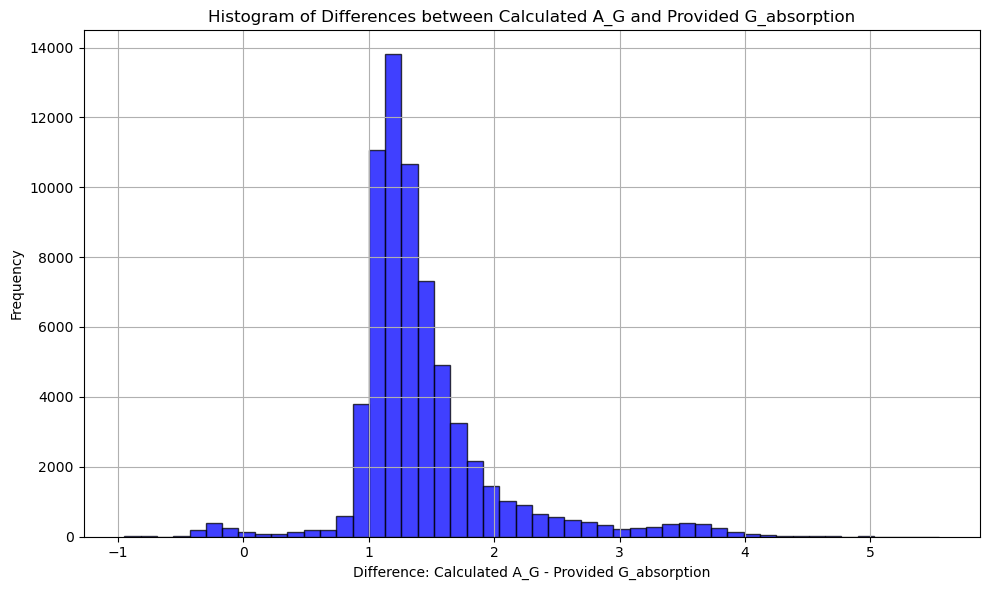

count    67441.000000
mean         1.429651
std          0.583013
min         -0.948949
25%          1.128260
50%          1.290190
75%          1.560456
max          5.548491
Name: AG_difference, dtype: float64

In [174]:
all_rrlyrae_gaia_data_df['AG_difference'] = all_rrlyrae_gaia_data_df['A_G'] - all_rrlyrae_gaia_data_df['G_absorption']
plt.figure(figsize=(10, 6))
plt.hist(all_rrlyrae_gaia_data_df['AG_difference'], bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Difference: Calculated A_G - Provided G_absorption')
plt.ylabel('Frequency')
plt.title('Histogram of Differences between Calculated A_G and Provided G_absorption')
plt.grid(True)
plt.tight_layout()
plt.show()
all_rrlyrae_gaia_data_df['AG_difference'].describe()

26. Plot a 2-d map of E (GBP − GRP ) as a function of Galactic longitude and latitude, using an Aitoff projection. A simple way to do this is to plot each RR Lyrae as a point in a scatter plot with semitransparent points, coloring each point by its AG. When you first make the plot, you will find that some large-scale structure is clearly visible, but also that there are some points for which the reddening looks clearly wrong; i.e., the color excess in one point is very different from the adjacent points. Construct appropriate quality cuts to remove these objects. You may want to cut on photometric signal-to-noise and/or BP/RP excess. To ensurereasonable spatial coverage, you should not have any less than ∼ 60, 000 stars (and you may have more). Be sure to clearly explain your cuts and the effects they have on the resulting map.

Total number of stars before any cuts: 115114
Number of stars after magnitude validity cut: 112477
Number of stars after BP-RP excess factor cut: 61332
Number of stars after combined quality cut: 61332


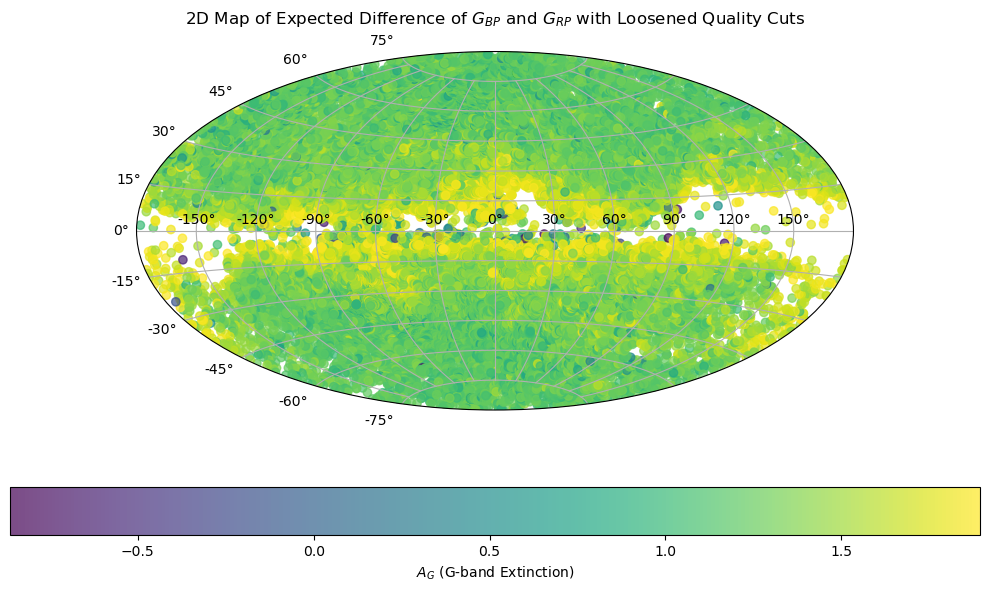

In [156]:
# Total number of stars before any cuts
total_stars = len(all_rrlyrae_gaia_data_df)
print(f"Total number of stars before any cuts: {total_stars}")

# Magnitude Validity Cut
bp_mag_valid = all_rrlyrae_gaia_data_df['phot_bp_mean_mag'] > 0
rp_mag_valid = all_rrlyrae_gaia_data_df['phot_rp_mean_mag'] > 0
mag_cut = bp_mag_valid & rp_mag_valid
stars_after_mag_cut = mag_cut.sum()
print(f"Number of stars after magnitude validity cut: {stars_after_mag_cut}")

# Loosened BP-RP Excess Factor Cut
bp_rp_excess_lower_bound = 0.72
bp_rp_excess_upper_bound = 2.6
excess_cut = (
    (all_rrlyrae_gaia_data_df['excess_ratio'] > bp_rp_excess_lower_bound) &
    (all_rrlyrae_gaia_data_df['excess_ratio'] < bp_rp_excess_upper_bound)
)
stars_after_excess_cut = excess_cut.sum()
print(f"Number of stars after BP-RP excess factor cut: {stars_after_excess_cut}")

# Combined Quality Cut
quality_cut = mag_cut & excess_cut
filtered_df = all_rrlyrae_gaia_data_df[quality_cut]
num_stars = len(filtered_df)
print(f"Number of stars after combined quality cut: {num_stars}")

coords = SkyCoord(
    ra=filtered_df['ra'].values * u.deg, 
    dec=filtered_df['dec'].values * u.deg, 
    frame='icrs'
)

galactic_coords = coords.galactic
l = galactic_coords.l.wrap_at(180 * u.deg).radian
b = galactic_coords.b.radian  

plt.figure(figsize=(10, 6))
plt.subplot(111, projection="aitoff")

sc = plt.scatter(l, b, c=filtered_df['A_G'], cmap='viridis', alpha=0.7)

cbar = plt.colorbar(sc, orientation="horizontal")
cbar.set_label(r'$A_G$ (G-band Extinction)')

plt.title(r'2D Map of Expected Difference of $G_{BP}$ and $G_{RP}$ with Loosened Quality Cuts', pad=20)
plt.grid(True)

plt.tight_layout()
plt.show()


### Magnitude Validity Cut

The magnitude validity cut ensures that only stars with positive values for their Blue Photometer (BP) and Red Photometer (RP) mean magnitudes are included in the analysis.

##### Why it’s important:

The BP and RP magnitudes represent the star's brightness in Gaia’s blue and red photometric bands, respectively. Occasionally, these magnitudes can be zero or negative due to data processing issues or errors during observations. Non-positive values are not physically meaningful in this context, so they indicate unreliable photometry. By filtering out stars with non-positive magnitudes, we maintain the integrity and accuracy of the data.

##### Our Cut:

We filtered the dataset to only include stars with positive BP and RP magnitudes.

##### Effect:

This cut eliminates stars with unreliable photometric data, ensuring that the remaining dataset consists of stars with valid, physically meaningful BP and RP magnitudes. This is a key step in ensuring that all subsequent calculations, such as color excess and extinction, are based on robust data.


### BP-RP Excess Ratio Cut

The BP/RP excess ratio is a quality metric that measures the consistency between the fluxes from the BP (blue) and RP (red) photometric bands. Ideally, these fluxes should be consistent, but deviations can occur due to contamination from nearby sources or other observational issues.

##### Why it’s important:

A large BP/RP excess ratio indicates that the star's photometry may be unreliable, potentially caused by contamination, calibration issues, or intrinsic properties of the star itself. By applying this cut, we filter out stars with excessive photometric inconsistencies, which helps in ensuring that the data is clean and trustworthy.

##### The Standard Gaia Recommendation:

Gaia DR3 recommends the following bounds for the BP/RP excess ratio to identify reliable photometry:
$
1.0 + 0.015 \times (GBP - GRP)^2 < \text{Excess Ratio} < 1.3 + 0.06 \times (GBP - GRP)^2
$

These bounds are dependent on the color of the star, meaning that stars with different GBP-GRP values will have slightly different acceptable ranges for the BP/RP excess ratio.

##### Our Loosened Cut:

To ensure we retain enough stars in our analysis, we relaxed the standard excess ratio bounds to:
$
0.72 < \text{Excess Ratio} < 2.6
$

##### Explanation:

- **Lower Bound:** We slightly lowered the lower bound of the excess ratio to include stars that may have low excess ratios but are still reliable.
  
- **Upper Bound:** The upper bound was increased significantly to account for stars that might show slightly larger discrepancies in their BP/RP photometry due to external factors but are still of interest for analysis.

##### Effect:

This cut allows us to include stars that may have minor inconsistencies in their BP/RP fluxes without excluding too many stars from the dataset. By relaxing the bounds, we retain a sufficient number of stars for our analysis while still filtering out stars with extreme or clearly unreliable photometric data.

27. The most widely used Galactic dust map is the “SFD” map produced by Schlegel, Finkbeiner, and Davis 1998. Incidentally, all three authors have strong ties to UC Berkeley. Compare the attenuation map you produced above to the SFD map. You can query SFD using
the “dustmaps” Python package. You only need the SFD map; don’t worry about installing the larger
maps (some of which are several GB). Plot the SFD optical reddening map, E (B − V ), sampled at the same positions as your RR Lyrae
map. Does the general structure of your map agree with SFD? What about the small-scale details?

In [157]:
config['data_dir'] = '/Users/vardaantekriwal/Documents/astron128/personal_material/lab1/dustmaps/cache'
dustmaps.sfd.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


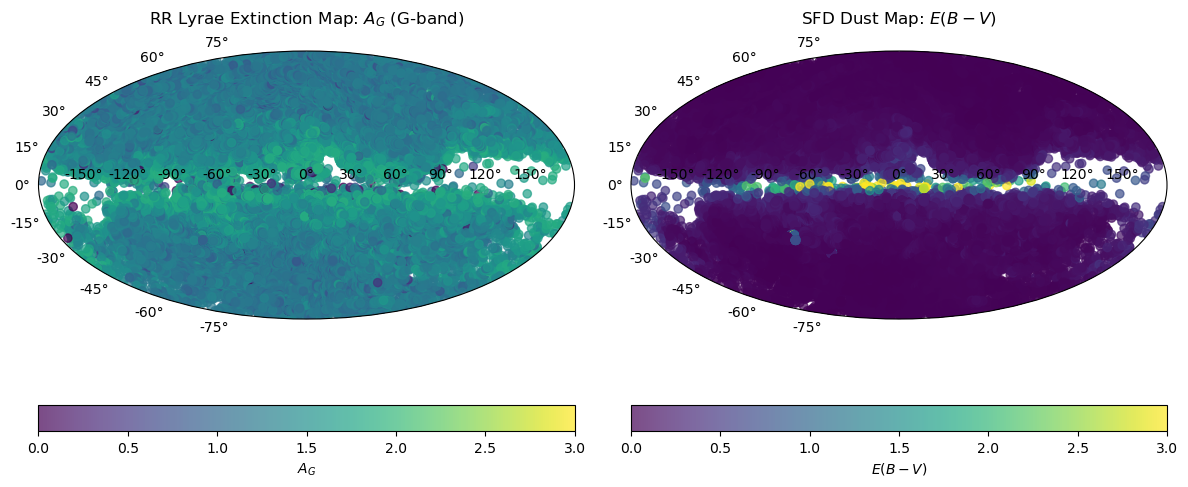

In [158]:
coords_icrs = SkyCoord(ra=filtered_df['ra'].values * u.deg, 
                       dec=filtered_df['dec'].values * u.deg, 
                       frame='icrs')

coords_galactic = coords_icrs.galactic
sfd = SFDQuery()
ebv_sfd = sfd(coords_galactic)
valid_mask = np.isfinite(filtered_df['A_G']) & np.isfinite(ebv_sfd) & np.isfinite(coords_galactic.l) & np.isfinite(coords_galactic.b)
l_valid = coords_galactic.l[valid_mask]
b_valid = coords_galactic.b[valid_mask]
A_G_valid = filtered_df['A_G'][valid_mask]
ebv_sfd_valid = ebv_sfd[valid_mask]

color_min = 0
color_max = 3
colormap = 'viridis'

plt.figure(figsize=(12, 6))
plt.subplot(121, projection='aitoff')
sc = plt.scatter(l_valid.wrap_at(180 * u.deg).radian, b_valid.radian, 
                 c=A_G_valid, cmap=colormap, alpha=0.7, vmin=color_min, vmax=color_max)
plt.title(r'RR Lyrae Extinction Map: $A_G$ (G-band)', pad = 20)
cbar = plt.colorbar(sc, orientation="horizontal")
cbar.set_label(r'$A_G$')

plt.subplot(122, projection='aitoff')
sc_sfd = plt.scatter(l_valid.wrap_at(180 * u.deg).radian, b_valid.radian, 
                     c=ebv_sfd_valid, cmap=colormap, alpha=0.7, vmin=color_min, vmax=color_max)
plt.title(r'SFD Dust Map: $E(B - V)$', pad = 20)
cbar_sfd = plt.colorbar(sc_sfd, orientation="horizontal")
cbar_sfd.set_label(r'$E(B - V)$')
plt.tight_layout()
plt.show()

## General Structure
The overall structure of the two maps shows broad agreement. Both maps display a concentration of higher extinction/dust values (darker colors) along the galactic plane, which runs horizontally across the center of each map. The polar regions in both maps show generally lower extinction/dust values (lighter colors).

### Key Similarities in Large-Scale Structure:
- Higher extinction band along the galactic plane
- Lower extinction in the polar regions
- Some patchy areas of higher extinction extending away from the galactic plane

## Small-Scale Details
While the large-scale structures align, there are noticeable differences in the fine details:

- **Coverage**: The RR Lyrae map has more gaps (white spaces), especially at lower galactic latitudes. The SFD map provides more complete coverage.
- **Intensity Variations**: The RR Lyrae map shows more variation in extinction levels, with a wider range of colors visible. The SFD map appears more uniformly dark purple, suggesting less variation in measured dust levels.
- **Specific Features**: Some localized features appear in one map but not the other. For example, there are several bright spots in the RR Lyrae map that don't have clear counterparts in the SFD map.


28. Do you expect your map to look exactly like SFD? Hint: think about how the SFD map is constructed.
What are the differences between what it measured and what your map measures?

## Measurement Method

- **SFD Map**: Constructed using far-infrared emission from dust, primarily measured by IRAS and COBE satellites.
- **RR Lyrae Map**: Based on the extinction measurements of RR Lyrae variable stars.

## What's Being Measured

- **SFD Map**: Measures total dust column density along the line of sight through the entire Galaxy.
- **RR Lyrae Map**: Measures extinction to specific RR Lyrae stars, which are located at various distances within the Galaxy.

## Depth

- **SFD Map**: Integrates dust all the way to the edge of the Galaxy.
- **RR Lyrae Map**: Only sensitive to dust between us and each RR Lyrae star, which have varying but finite distances.

## Resolution and Coverage

- **SFD Map**: Provides full-sky coverage with relatively uniform resolution.
- **RR Lyrae Map**: Coverage limited to areas where RR Lyrae stars have been observed, leading to patchier coverage.

## Sensitivity to Different Dust Properties

- **SFD Map**: Sensitive to dust temperature and emissivity.
- **RR Lyrae Map**: Sensitive to dust opacity in visible light.

## Key Expected Differences

- The **RR Lyrae map** may show less extinction in some areas, especially toward the Galactic center or in dense dust regions, as it doesn't capture dust beyond the RR Lyrae stars.
- The **RR Lyrae map** might reveal three-dimensional structure in the dust distribution that the SFD map cannot, as it's sensitive to dust at different distances.
- Areas with few or no RR Lyrae stars will have gaps in the **RR Lyrae map**, but will still have data in the SFD map.
- The **RR Lyrae map** might be less affected by very cold dust that the SFD map would detect, potentially leading to discrepancies in some regions.
- The **resolution and detail level** will differ, with the RR Lyrae map potentially showing more variation on smaller scales in well-sampled regions.
